In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams['figure.dpi'] = 100
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import numpy as np
import pandas as pd
import pickle

import os
import requests
from io import BytesIO
from io import StringIO

from astropy.table import Table
from astropy.table import join
from astropy.io import ascii
import astropy.constants as c


# Function to get NASA Exoplanet Archive catalogs 
# from Dan Foreman-Mackey (https://github.com/dfm/exopop)
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
        
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

#To track the provenance of different columns, we want a function to prepend an informative string to each column name.
#We will do this before merging tables to make tracking the information easier.
def prepend_dataframe_columns(df, prefix):
    df.columns = [prefix+col for col in df.columns]
    return 

### CKS VII Sample (Fulton & Petigura 2018)
As a starting point we will begin with the CKS VII sample. This includes some planets which were not contained in Kepler Q1-Q17 DR25, so it allows us to study a larger sample.

In [3]:
data_dir = "../data/"

cks_st = Table.read(data_dir+"Fulton2018_stellarradii_ajaae828t2_mrt.txt", format='ascii')
cks_pl = Table.read(data_dir+"Fulton2018_planetradii_ajaae828t3_mrt.txt", format='ascii')

# In order to join the tables we need to reformat the KOI identifiers
cks_pl['KOI_star'] = np.array([(x.split(".")[0]) for x in cks_pl['KOI']])
cks_st.rename_column('KOI', 'KOI_star')

# Join the CKS tables
cks = join(cks_pl, cks_st, join_type='left', keys='KOI_star')

# Prepend a prefix to each column to help keep track of the provenance of the data
cks = cks.to_pandas()
prepend_dataframe_columns(cks, 'f18_')
cks.head(5)

# Planet detection statistics
cks_stats = Table.read('http://cdsarc.unistra.fr/ftp/J/AJ/156/264/table4.dat',
                 readme='http://cdsarc.unistra.fr/ftp/J/AJ/156/264/ReadMe',
                 format='ascii.cds')

cks_stats.info()
cks_stats = cks_stats.to_pandas()

cks = cks.merge(cks_stats, how='left', left_on='f18_KOI', right_on='KOI')

<Table length=907>
 name   dtype                      description                    
------ ------- ---------------------------------------------------
   KOI    str9     Kepler Object of Interest identfier (K0NNNN.NN)
   S/N float64 [4.19/4012.61] Signal-to-noise ratio in i bandimage
  Pdet float64                         [0/1] Detection probability
   Ptr float64                 [0.0016/0.3251] Transit probability
Weight float64                [3.28/7117158.76] Weight, 1/w_i_ (1)


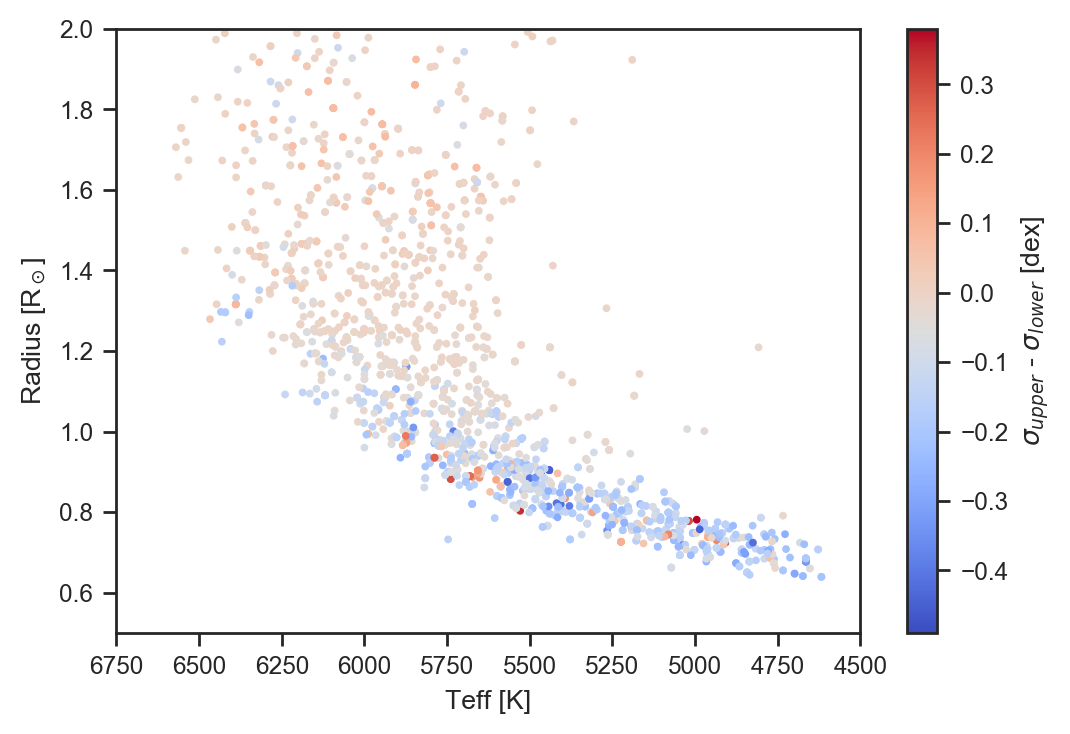

In [239]:
plt.scatter(cks['f18_Teff'], cks['f18_R'], c=cks['f18_E_logAiso']-cks['f18_e_logAiso'], s=4, cmap='coolwarm')
plt.ylim(0.5,2)
plt.xlim(6750,4500)
plt.colorbar(label=r'$\sigma_{upper}$ - $\sigma_{lower}$ [dex]')
plt.xlabel('Teff [K]')
plt.ylabel(r'Radius [R$_\odot$]')
plt.show()

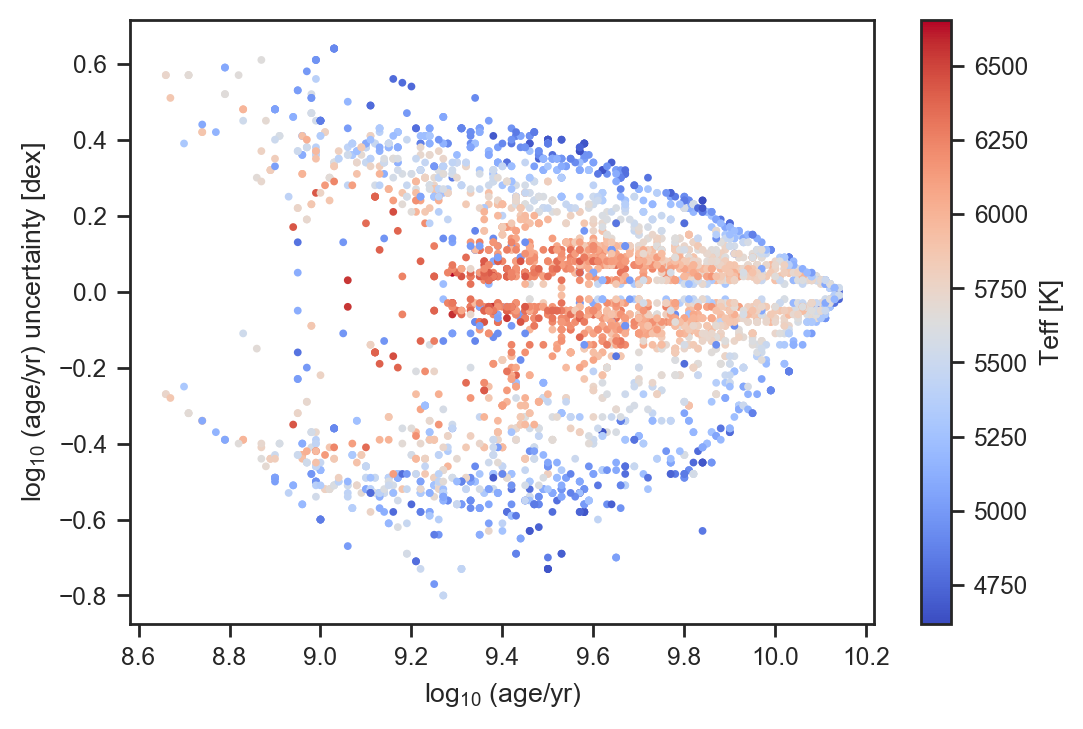

In [240]:
plt.scatter(cks['f18_logAiso'], cks['f18_E_logAiso'], c=cks['f18_Teff'], s=4, cmap='coolwarm')
plt.scatter(cks['f18_logAiso'], -cks['f18_e_logAiso'], c=cks['f18_Teff'], s=4, cmap='coolwarm')

plt.colorbar(label='Teff [K]')
plt.xlabel(r'log$_\mathregular{10}$ (age/yr)')
plt.ylabel(r'log$_\mathregular{10}$ (age/yr) uncertainty [dex]')
plt.show()

### CKS I (Petigura et al. 2017)
For consistency with CKS VII, we will use the false positive designations adopted in Table 4 of CKS I, which themselves are based on a compilation of planet candidate dispositions from Morton et al. (2016), Mullaly et al. (2015), and the NASA Exoplanet Archive (as it was on Feb. 1, 2017).

In [4]:
p17 = Table.read('http://cdsarc.unistra.fr/ftp/J/AJ/154/107/table4.dat',
                 readme='http://cdsarc.unistra.fr/ftp/J/AJ/154/107/ReadMe',
                 format='ascii.cds')

p17 = p17.to_pandas()
#Munging
p17['Name'] = [x.replace('OI-', '') for x in p17['Name']]
p17 = p17.rename(columns={'Name':'KOI'})
prepend_dataframe_columns(p17, 'p17_')

p17.head()

,p17_KOI,p17_Disp,p17_M16,p17_M15,p17_NEA
0,K00001.01,CP,CP,CP,CP
1,K00002.01,CP,CP,CP,CP
2,K00003.01,CP,CP,CP,CP
3,K00006.01,FP,FP,FP,FP
4,K00007.01,CP,CP,CP,CP


### Kepler Q1-Q17 DR25 table
As a starting point we begin with the [Kepler Q1-Q17 DR 25 KOI Table](https://exoplanetarchive.ipac.caltech.edu/docs/PurposeOfKOITable.html#q1-q17_dr25) which is described in [Thompson et al. 2018](https://arxiv.org/abs/1710.06758)

In [5]:
dr25 = get_catalog('q1_q17_dr25_koi')
prepend_dataframe_columns(dr25, 'dr25_')
dr25.head()

,dr25_kepid,dr25_kepoi_name,dr25_kepler_name,dr25_ra,dr25_ra_err,dr25_ra_str,dr25_dec,dr25_dec_err,dr25_dec_str,dr25_koi_gmag,...,dr25_koi_fpflag_co,dr25_koi_fpflag_ec,dr25_koi_insol,dr25_koi_insol_err1,dr25_koi_insol_err2,dr25_koi_srho,dr25_koi_srho_err1,dr25_koi_srho_err2,dr25_koi_fittype,dr25_koi_score
0,10811496,K00753.01,NaN,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,0,0,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.0
1,10848459,K00754.01,NaN,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,0,0,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.0
2,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,0,0,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.0
3,10872983,K00756.01,Kepler-228 d,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,114.81,112.85,-36.70,0.67324,0.33286,-0.38858,LS+MCMC,1.0
4,10872983,K00756.02,Kepler-228 c,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,427.65,420.33,-136.70,0.37377,0.74768,-0.26357,LS+MCMC,1.0


### Kepler Stellar Data
We will also want the [Kepler Stellar data table](https://exoplanetarchive.ipac.caltech.edu/docs/Kepler_completeness_reliability.html) for the noise properties of each planet host. Since this is a large table, we have extracted the only columns we want ahead of time and stored this in the data directory.

In [7]:
stlr = pd.read_csv(data_dir+'Kepler-Q1-Q17-DR25-CDPP3.csv')
prepend_dataframe_columns(stlr, 'stlr_')
stlr.head()

,stlr_kepid,stlr_rrmscdpp03p0
0,10000785,445.410
1,10000797,80.767
2,10000800,226.348
3,10000823,181.468
4,10000827,124.834


### Gaia Kepler Stellar Properties Catalog (Berger et al. 2020)

In [8]:
# b20 = pd.read_csv(data_dir+'GKSPCPapTable2.txt', delimiter='&')

# #Munging of TAMS column (terminal age main sequence)
# b20['TAMS'] = [float(x.split('\\\\')[0]) for x in b20['TAMS']]

# #Adding columns for ease of access later
# b20['log10_iso_age']   = np.log10(1.0e9*b20['iso_age'])
# b20['E_log10_iso_age'] = np.log10(1.0e9*(b20['iso_age']+b20['iso_age_err1'])) - b20['log10_iso_age']
# b20['e_log10_iso_age'] = b20['log10_iso_age'] - np.log10(1.0e9*(b20['iso_age']+b20['iso_age_err2']))

# #Prefixes to track provenance
# prepend_dataframe_columns(b20, 'b20_')
# b20.head()

,b20_KIC,b20_iso_mass,b20_iso_mass_err1,b20_iso_mass_err2,b20_iso_teff,b20_iso_teff_err1,b20_iso_teff_err2,b20_iso_logg,b20_iso_logg_err1,b20_iso_logg_err2,...,b20_iso_age_err2,b20_iso_dis,b20_iso_dis_err1,b20_iso_dis_err2,b20_iso_avs,b20_iso_gof,b20_TAMS,b20_log10_iso_age,b20_E_log10_iso_age,b20_e_log10_iso_age
0,757076,1.396,0.179,-0.218,5052.2,103.9,-86.6,3.373,0.067,-0.081,...,-0.73,651.5,22.6,-21.6,0.371,1.0,2.69,9.392697,0.239760,0.152148
1,757099,0.873,0.054,-0.039,5364.9,102.7,-84.9,4.318,0.037,-0.029,...,-3.98,367.8,7.1,-6.9,0.340,1.0,17.18,10.181844,0.078228,0.131851
2,757137,1.669,0.309,-0.300,4628.7,84.8,-76.2,2.388,0.083,-0.086,...,-0.58,568.4,12.2,-11.6,0.344,1.0,1.66,9.178977,0.230956,0.210494
3,757280,1.715,0.086,-0.089,6856.8,144.4,-139.9,3.834,0.033,-0.032,...,-0.16,822.0,19.4,-21.0,0.496,1.0,1.62,9.093422,0.064941,0.059998
4,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,-5.15,829.6,24.0,-23.4,0.465,1.0,16.10,9.975891,0.194957,0.341414


### Petigura 2020
The radius valley is partially contaminated by planets with poorly determined radius ratios due to high impact parameters (grazing or near-grazing transits). Petigura 2020 devised a method to eliminate these planets with high confidence without performing new light curve fits.

In [10]:
url = "https://raw.githubusercontent.com/petigura/keprat/master/data/cksgaia-planets.csv"
s = requests.get(url).content
p20 = pd.read_csv(StringIO(s.decode('utf-8')))
p20['Rtau'] = p20.tau/p20.tau0
prepend_dataframe_columns(p20, 'p20_')

p20.head()

,p20_id_kic,p20_id_starname,p20_id_kic.1,p20_id_koi,p20_id_koicand,p20_id_kepler_name,p20_koi_disposition,p20_koi_period,p20_koi_period_err1,p20_koi_period_err2,...,p20_fgraz,p20_tau0,p20_tau,p20_dr25_ror_v18_srad,p20_dr25_ror_v18_srad_err1,p20_dr25_ror_gdir_srad,p20_dr25_ror_gdir_srad_err1,p20_v18_ror_gdir_srad,p20_v18_ror_gdir_srad_err1,p20_Rtau
0,757450,K00889,757450,889.0,K00889.01,Kepler-75 b,CONFIRMED,8.884923,0.000001,-0.000001,...,0.0,4.019727,1.856715,NaN,NaN,11.802615,0.412225,NaN,NaN,0.461901
1,1026957,K00958,1026957,958.0,K00958.01,NaN,NOT DISPOSITIONED,21.761294,0.000011,-0.000011,...,0.0,4.427408,1.204967,NaN,NaN,2.478217,0.114768,NaN,NaN,0.272161
2,1718189,K00993,1718189,993.0,K00993.01,Kepler-262 c,CONFIRMED,21.853679,0.000097,-0.000097,...,0.0,4.914936,3.306574,NaN,NaN,1.551245,0.081248,NaN,NaN,0.672760
3,1718189,K00993,1718189,993.0,K00993.02,Kepler-262 b,CONFIRMED,13.060767,0.000092,-0.000092,...,0.0,4.139989,3.093553,NaN,NaN,1.267332,0.068661,NaN,NaN,0.747237
4,1718189,K00993,1718189,993.0,K00993.03,NaN,CANDIDATE,86.723152,0.001814,-0.001814,...,0.0,7.781345,4.761139,NaN,NaN,1.257706,0.094337,NaN,NaN,0.611866


### Gaia-Kepler cross-match catalog
Megan Bedell performed a 1 arcsecond positional cross-match of the Kepler and Gaia DR2 catalogs. The results are hosted [here](https://gaia-kepler.fun/).

In [11]:
# gaia = Table.read('/Users/tdavid/Dropbox (Simons Foundation)/multis/data/kepler_dr2_1arcsec.fits', format='fits')
# gaia = gaia.to_pandas()
# prepend_dataframe_columns(gaia, "gaia_")

# gaia = gaia.drop_duplicates(subset=['gaia_kepid'])
# gaia.head()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/tdavid/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/tdavid/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/tdavid/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


,gaia_solution_id,gaia_designation,gaia_source_id,gaia_random_index,gaia_gaia_ref_epoch,gaia_ra,gaia_ra_error,gaia_dec,gaia_dec_error,gaia_parallax,...,gaia_mass_err2,gaia_prov_sec,gaia_nconfp,gaia_nkoi,gaia_ntce,gaia_jmag,gaia_hmag,gaia_kmag,gaia_planet?,gaia_kepler_gaia_ang_dist
0,1635721458409799680,b'Gaia DR2 2050233807328471424',2050233807328471424,689405501,2015.5,291.038681,0.035878,36.598031,0.047832,1.493916,...,-0.475,b'DSEP',0,0,0,10.126,9.667,9.559,b'none',0.156160
1,1635721458409799680,b'Gaia DR2 2050233601176543104',2050233601176543104,447382505,2015.5,291.043057,0.019919,36.593767,0.027553,2.678194,...,-0.233,b'DSEP',0,0,1,11.656,11.193,11.094,b'none',0.128262
2,1635721458409799680,b'Gaia DR2 2050230543159814656',2050230543159814656,1004823384,2015.5,291.055892,0.019394,36.559886,0.026621,1.723413,...,-0.947,b'DSEP',0,0,0,7.467,6.853,6.722,b'none',0.146787
3,1635721458409799680,b'Gaia DR2 2050230611879323904',2050230611879323904,1253666653,2015.5,291.095373,0.016886,36.564903,0.022993,1.183652,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',0.116420
4,1635721458409799680,b'Gaia DR2 2050231848829944320',2050231848829944320,298032508,2015.5,291.137620,0.019560,36.577344,0.025196,1.168913,...,-0.040,b'DSEP',1,1,1,13.665,13.262,13.118,b'conf',0.114502


### Gaia DR2 RUWE values
I queried the Gaia archive for RUWE values for the Gaia DR2-Kepler cross-match catalog above.

In [247]:
# ruwe = Table.read(data_dir+'kepler_dr2_1arcsec_ruwe.fits', format='fits')
# ruwe = ruwe.to_pandas()
# prepend_dataframe_columns(ruwe, 'd20_')
# ruwe = ruwe.drop_duplicates(subset=['d20_kepid'])
# ruwe.head()

,d20_kepid,d20_source_id,d20_ruwe,d20_koi
0,757076,2050233807328471424,0.946665,NaN
1,757099,2050233601176543104,2.172801,NaN
2,757137,2050230543159814656,0.912556,NaN
3,757280,2050230611879323904,0.870375,NaN
4,757450,2050231848829944320,1.030048,889.0


### Results from fitting skew normal distributions to age PPFs from CKS

In [13]:
skew = pd.read_csv(data_dir+'cks-skewnormal-shape-parameters.csv')
skew.head()

,KOI,logAiso,E_logAiso,e_logAiso,a3,loc3,scale3,a5,loc5,scale5
0,K00001,9.74,0.13,0.15,-1.723381,9.866322,0.196824,-0.844107,9.817946,0.165594
1,K00002,9.25,0.04,0.05,-2.321427,9.294849,0.067507,-1.059536,9.278683,0.055756
2,K00006,9.32,0.09,0.24,-23.351389,9.482107,0.278910,-3.731076,9.472594,0.270625
3,K00007,9.78,0.09,0.08,1.544269,9.706938,0.116269,0.030719,9.789814,0.087285
4,K00008,9.18,0.26,0.52,-24.799017,9.590470,0.653710,-2.445676,9.518279,0.588301


### Merging tables

In [14]:
# First drop nine stars without CKS ages. 
# These present problems later in the MC simulation when attempting to sample from a skew normal distribution. 
# Excluding them changes nothing about the results.
cks = cks.dropna(subset=['f18_logAiso'])

In [16]:
print(len(cks))
cks = cks.merge(p17, how='left', left_on='f18_KOI', right_on='p17_KOI')
print(len(cks))
cks = cks.merge(dr25, how='left', left_on='f18_KOI', right_on='dr25_kepoi_name')
print(len(cks))
cks = cks.merge(stlr, how='left', left_on='dr25_kepid', right_on='stlr_kepid')
print(len(cks))
#cks = cks.merge(gaia, how='left', left_on='dr25_kepid', right_on='gaia_kepid')
#print(len(cks))
cks = cks.merge(p20, how='left', left_on='dr25_kepoi_name', right_on='p20_id_koicand')
print(len(cks))
#cks = cks.merge(b20, how='left', left_on='dr25_kepid', right_on='b20_KIC')
#print(len(cks))
#cks = cks.merge(ruwe, how='left', left_on='dr25_kepid', right_on='d20_kepid')
#print(len(cks))
cks = cks.merge(skew, how='left', left_on='f18_KOI_star', right_on='KOI')
print(len(cks))

1892
1892
1892
1892
1892
1892


### Defining new columns that will be used in the masks

In [17]:
cks['f18_depth_ppm'] = (cks['f18_Rp/R*']**2.0)/1e-6
cks['single_transit_snr'] = 1.0e6*((1.0*c.R_earth.value)/(cks['f18_R']*c.R_sun.value))**2. * 1.0/cks['stlr_rrmscdpp03p0']
cks['Rcut'] = 10.**((cks['f18_Teff']-5500)/4500 + 0.25) #Fulton & Petigura use 0.2 instead of 0.25
cks['nplanets'] =[np.sum(x == cks['f18_KOI_star']) for x in cks['f18_KOI_star']]

In [18]:
#Let's declare a new variable to store the original CKS dataframe, 
#as we will soon appply masks to restrict our analysis to a subset of the sample with high reliability.
cks_base = pd.DataFrame(cks)

In [19]:
#Plotting defaults
sns.set(font_scale=1, context="paper", style="ticks")
ebar_kwargs = {'alpha': 0.5, 'fmt':'o', 'ecolor': 'lightgrey', 'ms': 1, 'lw':0.5}
line_kwargs = {'ls':'--', 'color':'k', 'lw': 0.5}

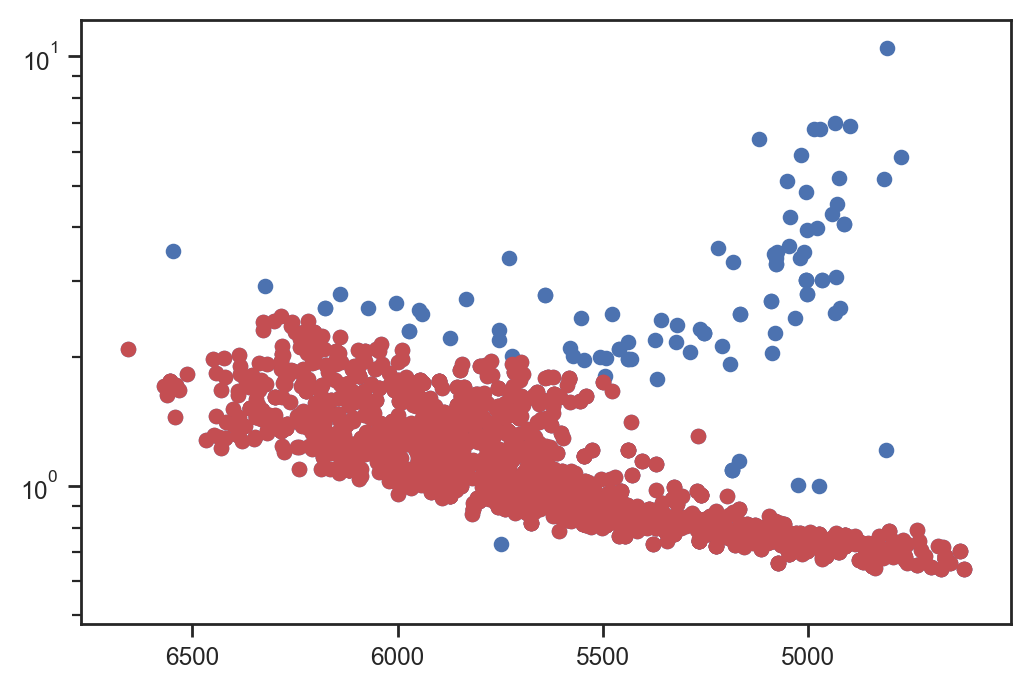

In [20]:
from scipy import interpolate 

# #Non-rotating solar metallicity MIST isochrones
# mist  = np.genfromtxt(data_dir+'mist/MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_basic.iso', skip_header=10, names=True)
# #Non-rotating Fe/H = -0.25 MIST isochrones
# mistm = np.genfromtxt(data_dir+'mist/MIST_v1.2_vvcrit0.0_basic_isos/MIST_v1.2_feh_m0.25_afe_p0.0_vvcrit0.0_basic.iso', skip_header=10, names=True)
#Non-rotating Fe/H = +0.25 MIST isochrones
mistp = np.genfromtxt(data_dir+'MIST_v1.2_feh_p0.25_afe_p0.0_vvcrit0.0_basic.iso', skip_header=10, names=True)
# #Rotating (v/vcrit=0.4) solar metallicity MIST isochrones
# mistr = np.genfromtxt(data_dir+'mist/MIST_v1.2_vvcrit0.4_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso', skip_header=10, names=True)

# Improved MS cut
def maxage_teff(rstar):
    arg = (mistp['log10_isochrone_age_yr']==10.25)&(mistp['EEP']<500)
    f = interpolate.interp1d(10.**mistp['log_R'][arg], 
                             10.**mistp['log_Teff'][arg], 
                             kind='cubic', fill_value='extrapolate')
    return f(rstar)


_teff = np.linspace(4500,7000,10)

#We wish to remove stars that obviously fall below the main sequence as these may have unreliable stellar parameters
m_onms = cks['f18_R'] > 10.**((cks['f18_Teff']-5500)/7000 - 0.15)
#Our study will focus stars which have not evolved far off the main sequence
m_unevolved = cks['f18_R'] < 10.**((cks['f18_Teff']-5500)/4500 + 0.25)
#Some cool stars appear to be elevated from the main-sequence, corresponding to ages older than the universe
#even if they are metal-rich.
m_unelevated = cks['f18_Teff'] > maxage_teff(cks['f18_R'])


#Plot the cut in the HR diagram
m_ms = m_onms & m_unevolved & m_unelevated

plt.scatter(cks['f18_Teff'], cks['f18_R'])
plt.scatter(cks['f18_Teff'][m_ms], cks['f18_R'][m_ms], color='r')
plt.gca().invert_xaxis()
plt.semilogy()
plt.show()

In [23]:
new_df = pd.DataFrame({'log10_isochrone_age_yr': mistp['log10_isochrone_age_yr'],
                       'EEP': mistp['EEP'],
                       'log_R': mistp['log_R'],
                       'log_Teff': mistp['log_Teff']})
new_df.to_feather(data_dir+'MIST_v1.2_feh_p0.25_afe_p0.0_vvcrit0.0_abridged.feather')


In [25]:
new_df.to_csv(data_dir+'MIST_v1.2_feh_p0.25_afe_p0.0_vvcrit0.0_abridged.csv')

In [24]:
tmp = pd.read_feather(data_dir+'MIST_v1.2_feh_p0.25_afe_p0.0_vvcrit0.0_abridged.feather')
tmp.head()

,log10_isochrone_age_yr,EEP,log_R,log_Teff
0,5.0,4.0,0.166496,3.442750
1,5.0,5.0,0.171345,3.443819
2,5.0,6.0,0.181645,3.446095
3,5.0,7.0,0.191905,3.448376
4,5.0,8.0,0.202097,3.450658


### Masks

In [256]:
mstar_min, mstar_max = 0.75, 1.25
period_max = 100.
r8_max = 1.1
rcf_max = 1.05
abs_feh_max = 0.15
ruwe_max = 1.4
rp_max = 5.
snr_min = 0.45

ag_max = 2
gkp_max = 1.0

dlogage_max = 1.0
sigmarp_max = 0.1

print(len(cks), 'planets')

# Remove False Positives
m_fp = cks['p17_Disp'] != 'FP'
print(len(cks[~m_fp]), 'planets with FP disposition')

# Remove stars with flux contamination determined from Gaia
m_r8 = cks['f18_r8'] < r8_max
print(len(cks[~m_r8]), 'planets fail r8 cut')

# Exclude stars with flux contamination from follow-up high-res imaging
m_RCF = np.invert(cks['f18_RCF'] >= rcf_max)
print(len(cks[~m_RCF]), 'planets fail RCF cut')

# Exclude long period planets
m_P = cks['f18_P'] < period_max
print(len(cks[~m_P]), 'planets fail period cut')

# Signal-to-noise cut
m_snr = cks['single_transit_snr'] > snr_min
print(len(cks[~m_snr]), 'planets fail SNR cut')

# Well-determined planet radii
m_radiusprec = np.all(np.array([cks['f18_e_Rp']/cks['f18_Rp'], cks['f18_E_Rp']/cks['f18_Rp']])<sigmarp_max, axis=0)
print(len(cks[~m_radiusprec]), 'planets fail radius precision cut')

# Small planets
m_rp = cks['f18_Rp']<rp_max
print(len(cks[~m_rp]), 'planets fail radius cut')

# RUWE cut // binary
m_ruwe = cks['d20_ruwe']<ruwe_max
print(len(cks[~m_ruwe]), 'planets fail RUWE cut')

# Stars with discrepant Gaia and isochrone parallaxes
m_parallaxagree = abs(cks['f18_plx']-cks['f18_plxspec'])/np.min(np.array([cks['f18_e_plxspec'],cks['f18_E_plxspec']]), axis=0) < 4
print(len(cks[~m_parallaxagree]), 'planets fail parallax agreement test')

# Planets with grazing transits
m_grazing = cks['p20_Rtau'] >= 0.6
print(len(cks[~m_grazing]), 'planets with grazing transits')

m_logaisonan = ~cks['f18_logAiso'].isna()
print(len(cks[~m_logaisonan]), 'planets have undefined logAiso')

m_misonan = (cks['f18_Miso']>0)
print(len(cks[~m_misonan]), 'planets have zero mass')

m = m_ms & m_fp & m_P & m_snr & m_r8 & m_RCF & m_ruwe & m_radiusprec & m_logaisonan & m_parallaxagree & m_rp
print(len(cks[m]), 'planets remaining after cuts')


m = m_ms & m_fp & m_P & m_snr & m_radiusprec & m_rp & m_radiusprec & m_misonan & m_logaisonan & m_parallaxagree
print(len(cks[m]), 'planets remaining after cuts')

# Finite shape parameters from skew normal fits
m_shape = np.isfinite(cks['loc3'])
print(len(cks[~m_shape]), 'planets do not have finite shape parameters')


#Submitted version:
#base_sample = m_fp & m_P & m_snr & m_misonan & m_logaisonan & m_parallaxagree #& m_radiusprec
base_sample = m_fp & m_P & m_snr & m_misonan & m_logaisonan & m_parallaxagree & m_shape #& m_radiusprec

#base_sample = m_fp & m_ms & m_P & m_rp & (cks['single_transit_snr']>0.5)

print(len(cks[base_sample]), 'planets remaining after cuts')
print(len(np.unique(cks['f18_KOI_star'][base_sample])), 'unique hosts remaining after cuts')

1892 planets
148 planets with FP disposition
134 planets fail r8 cut
70 planets fail RCF cut
222 planets fail period cut
524 planets fail SNR cut
314 planets fail radius precision cut
233 planets fail radius cut
222 planets fail RUWE cut
91 planets fail parallax agreement test
589 planets with grazing transits
0 planets have undefined logAiso
0 planets have zero mass
897 planets remaining after cuts
998 planets remaining after cuts
0 planets do not have finite shape parameters
1158 planets remaining after cuts
718 unique hosts remaining after cuts


/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less


In [201]:
# Handling stars with missing skew normal shape parameters. 
# This only affects 9 stars, and we replace their shape parameters with those for a normal distributon.
#cks['loc3'][~m_shape] = cks['f18_logAiso'][~m_shape]
#cks['scale3'][~m_shape] = cks['f18_logAiso'][~m_shape]

0.4363636363636364 0.01607034794444491
0.4424242424242425 0.0341441751059422
0.44848484848484854 0.024051007965275165
0.4787878787878788 0.017796733658477504
0.4848484848484849 0.03237018599024217
0.49090909090909096 0.041733980534423336
0.496969696969697 0.08286179956103511
0.5030303030303032 0.12090757122208955
0.5090909090909091 0.12436881221745523
0.5151515151515151 0.17824059593281782
0.5212121212121212 0.3201588596437111
0.5272727272727273 0.3598481772522396
0.5333333333333334 0.4030200939194418
0.5393939393939395 0.394069139461391
0.5454545454545455 0.8134000065155869
0.5515151515151515 0.7595004184162789
0.5575757575757576 0.4878772756352998
0.5636363636363637 0.4134964720739005
0.5696969696969698 0.3079742955493805
0.5757575757575758 0.5044854090050728
0.5818181818181819 0.43280138090893305
0.5878787878787879 0.4733217954536082
0.593939393939394 0.5141259945723229
0.6000000000000001 0.9278669591945086
0.6060606060606062 0.8430240467287011
0.6121212121212122 0.8431266546348855


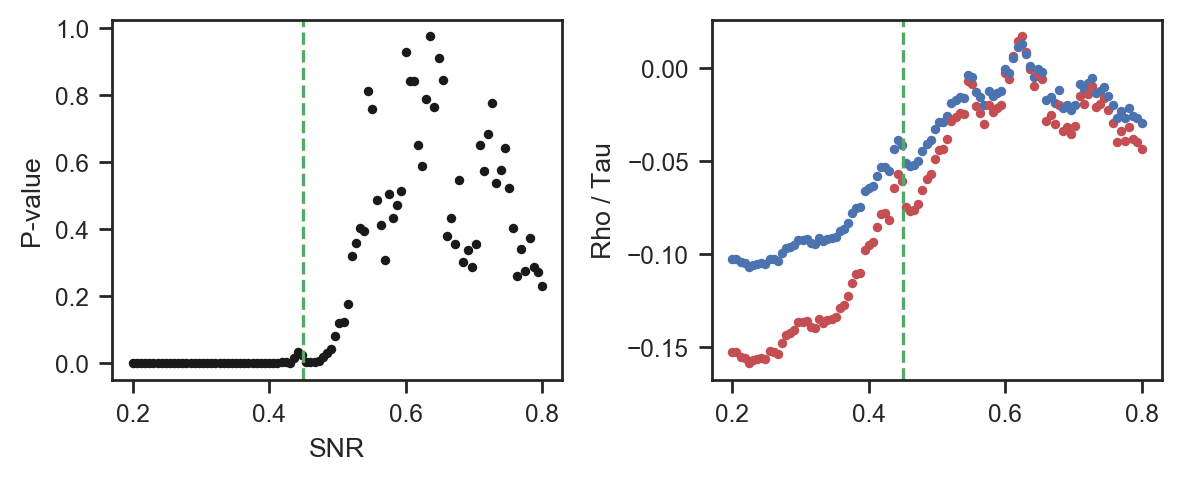

In [202]:
age = cks['f18_logAiso']

#snrgrid = np.logspace(-1,0,100)
snrgrid = np.linspace(0.2,0.8,100)
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(6,2.5))
for _snr in snrgrid:
    newm = (cks['single_transit_snr']>_snr) & (np.isfinite(cks['f18_logAiso']))
    rho, pval = stats.spearmanr(age[newm], cks['single_transit_snr'][newm])
    ax1.plot(_snr, pval, 'k.')
    tau, _pval = stats.kendalltau(age[newm], cks['single_transit_snr'][newm])
    ax2.plot(_snr, rho, 'r.')
    ax2.plot(_snr, tau, 'b.')
    if pval>0.01:
        print(_snr, pval)
    
ax1.axvline(snr_min, ls='--', color='g')
ax2.axvline(snr_min, ls='--', color='g')
ax1.set_xlabel('SNR')
ax1.set_ylabel('P-value')
ax2.set_ylabel('Rho / Tau')
plt.tight_layout()
plt.show()

0.01 0.006586010128724344
0.01191919191919192 0.005715019039071137
0.013838383838383839 0.005715019039071137
0.01575757575757576 0.005715019039071137
0.017676767676767676 0.005715019039071137
0.019595959595959597 0.005715019039071137
0.021515151515151515 0.08938579174390794
0.023434343434343433 0.08938579174390794
0.025353535353535354 0.08938579174390794
0.027272727272727275 0.08938579174390794
0.029191919191919193 0.08938579174390794
0.03111111111111111 0.010188984079481952
0.03303030303030303 0.010188984079481952
0.03494949494949495 0.010188984079481952
0.03686868686868687 0.010188984079481952
0.03878787878787879 0.010188984079481952
0.040707070707070706 0.00020378272955495273
0.04262626262626263 0.00020378272955495273
0.04454545454545455 0.00020378272955495273
0.046464646464646465 0.00020378272955495273
0.04838383838383838 0.00020378272955495273
0.05030303030303031 0.0014521568504897583
0.052222222222222225 0.0014521568504897583
0.05414141414141414 0.0014521568504897583
0.0560606060

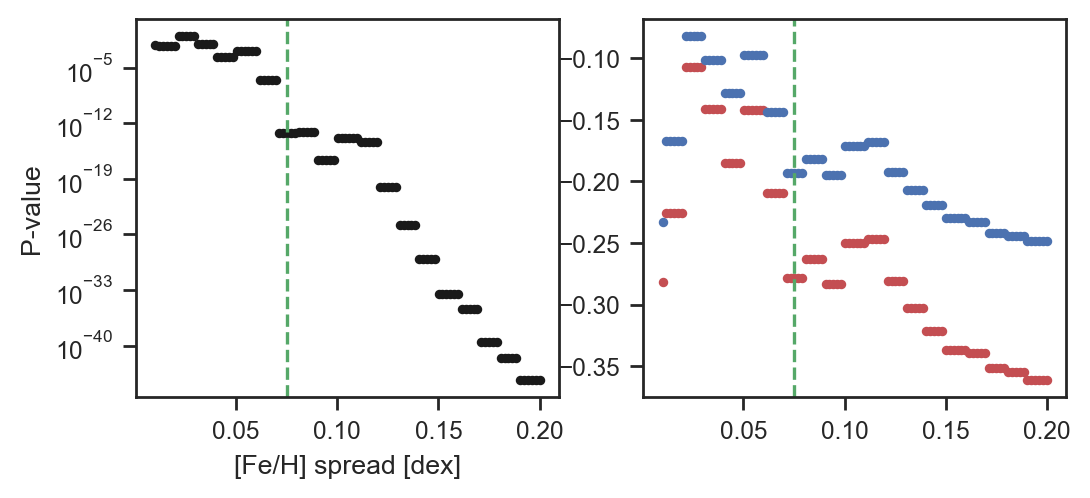

In [203]:
fehgrid = np.linspace(0.01,0.2,100)

_base = (np.isfinite(cks['f18_logAiso'])) & (np.isfinite(cks['f18_[Fe/H]'])) & (cks['f18_Miso']>0.0)

fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(6,2.5))
for _fehwid in fehgrid:
    newm = _base & (abs(cks['f18_[Fe/H]']-np.median(cks['f18_[Fe/H]']))<_fehwid)
    rho, pval = stats.spearmanr(age[newm], cks['f18_[Fe/H]'][newm])
    ax1.plot(_fehwid, pval, 'k.')
    tau, _pval = stats.kendalltau(age[newm], cks['f18_[Fe/H]'][newm])
    ax2.plot(_fehwid, rho, 'r.')
    ax2.plot(_fehwid, tau, 'b.')
    
    if pval>0.0001:
        print(_fehwid, pval)    
    
ax1.axvline(0.075, ls='--', color='g')
ax2.axvline(0.075, ls='--', color='g')
ax1.set_xlabel('[Fe/H] spread [dex]')
ax1.set_ylabel('P-value')
ax1.semilogy()
plt.show()

0.6616161616161617 0.5821369516625028
0.6717171717171717 0.865104360440585
0.6818181818181819 0.527946163009779
0.6919191919191919 0.1156403499606572
0.702020202020202 0.6777862455129047
0.7121212121212122 0.3368685290385751
0.7222222222222222 0.7457559551697613
0.7323232323232324 0.12651477190765084
0.7424242424242424 0.4650477925740918
0.7525252525252526 0.22766805795122297
0.7626262626262627 0.11440177118033393
0.7727272727272727 0.12655740612309996
0.7828282828282829 0.2002247899412746
0.7929292929292929 0.6823895589856401
0.803030303030303 0.05098030111510447
0.8131313131313131 0.08186546617977057
0.8232323232323233 0.03981187998820459
0.8333333333333334 0.24495317515486428
0.8434343434343434 0.2333857662566552
0.8535353535353536 0.679504854152646
0.8636363636363636 0.8612577534509481
0.8737373737373737 0.7706997933107498
0.8838383838383839 0.5625298477576768
0.893939393939394 0.5549986162058622
0.9040404040404041 0.6186475061132728
0.9141414141414141 0.3699501264439412
0.92424242

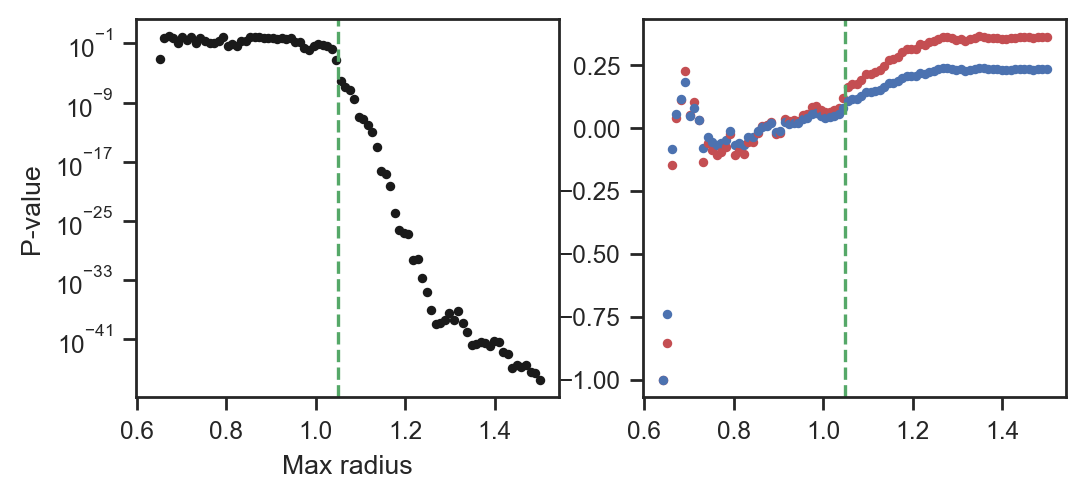

In [204]:
rstargrid = np.linspace(0.5,1.5,100)

_base = (np.isfinite(cks['f18_logAiso'])) & (np.isfinite(cks['f18_[Fe/H]'])) & (cks['f18_Miso']>0.0)

fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(6,2.5))

for rmax in rstargrid:
    newm = _base & (cks['f18_R']<rmax)
    rho, pval = stats.spearmanr(age[newm], cks['f18_R'][newm])    
    ax1.plot(rmax, pval, 'k.')
    tau, _pval = stats.kendalltau(age[newm], cks['f18_R'][newm])    
    ax2.plot(rmax, rho, 'r.')
    ax2.plot(rmax, tau, 'b.')
    if pval>0.01:
        print(rmax, pval)        
    
ax1.axvline(1.05, ls='--', color='g')
ax2.axvline(1.05, ls='--', color='g')
ax1.set_xlabel('Max radius')
ax1.set_ylabel('P-value')
ax1.semilogy()
plt.show()

In [77]:
# mstargrid = np.linspace(0.5,1.5,100)

# _base = (np.isfinite(cks['f18_logAiso'])) & (np.isfinite(cks['f18_[Fe/H]'])) & (cks['f18_Miso']>0.0)

# fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(6,2.5))

# for mmax in mstargrid:
#     newm = _base & (cks['f18_Miso']<mmax)
#     rho, pval = stats.spearmanr(age[newm], cks['f18_Miso'][newm])
#     plt.plot(mmax, pval, 'k.')
#     if pval>0.05:
#         print(mmax, pval)        
    
    
# #plt.axvline(1.05, ls='--', color='r')
# plt.xlabel('Max Mass')
# plt.ylabel('P-value')
# plt.semilogy()
# plt.show()

### Figure overwrite?

In [205]:
fig_overwrite = False

112 planets in the young sample
90 planets in the old sample
202 planets in the restricted sample
117 unique hosts in the restricted sample


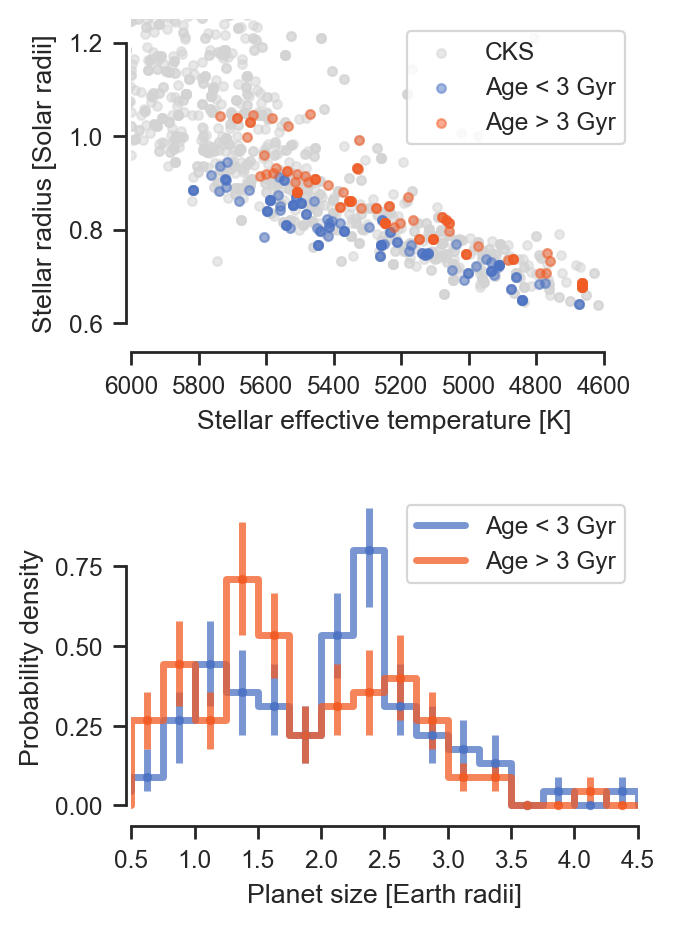

In [206]:
import matplotlib.pyplot as plt
plt.rc("axes.spines", top=False, right=False)

#yng_color = '#d4689f'
#old_color = '#597cde'

#yng_color = '#6660C6'
#yng_color = '#616ec2'
yng_color = '#4d73c4'
old_color = '#f25b24'
#old_color = '#F0593E'

scatter_kwargs = {'alpha': 0.5, 's': 10}

restricted_sample = m_fp & m_P & m_rp & m_snr &\
                    (cks['f18_Miso']<1) &\
                    (abs(cks['f18_[Fe/H]']-np.median(cks['f18_[Fe/H]']))<0.075) &\
                    (cks['f18_R']<1.05)


yng = restricted_sample & (cks['f18_logAiso']<np.log10(3e9))
old = restricted_sample & (cks['f18_logAiso']>np.log10(3e9))

#yng = base & (cks['f18_Teff']>5500) & (cks['f18_logAiso']<np.log10(3e9))
#old = base & (cks['f18_Teff']>5500) & (cks['f18_logAiso']>np.log10(3e9))

plt.subplot(211)
plt.scatter(cks['f18_Teff'], cks['f18_R'], label='CKS',  color='lightgrey', **scatter_kwargs)
plt.scatter(cks['f18_Teff'][yng], cks['f18_R'][yng], label='Age < 3 Gyr', color=yng_color, **scatter_kwargs)
plt.scatter(cks['f18_Teff'][old], cks['f18_R'][old], label='Age > 3 Gyr', color=old_color, **scatter_kwargs)

plt.xlim(6000,4500)
plt.ylim(0.55,1.25)

#plt.xlim(7000,4500)
#plt.ylim(0.55,2)

plt.ylabel('Stellar radius [Solar radii]')
plt.xlabel('Stellar effective temperature [K]')
plt.legend()
#plt.semilogy()



plt.subplot(212)

#Old
# rpbins = np.arange(0.5,4.5,0.25)
# plt.hist(cks['f18_Rp'][tmp2], bins=rpbins, histtype='step', density=False, lw=2, label='Age > 3 Gyr', color=old_color, alpha=0.75)
# plt.hist(cks['f18_Rp'][tmp1], bins=rpbins, histtype='step', density=False, lw=2, label='Age < 3 Gyr', color=yng_color, alpha=0.75)
# plt.xlabel('Planet size [Earth radii]')
# plt.ylabel('Number of planets')
# plt.legend()
# plt.xticks(np.arange(0.5,5,0.5))


x1 = cks['f18_Rp'][yng]
x1err = cks['f18_E_Rp'][yng]
x2 = cks['f18_Rp'][old]
x2err = cks['f18_E_Rp'][old]

print(len(cks[yng]), 'planets in the young sample')
print(len(cks[old]), 'planets in the old sample')
print(len(cks[restricted_sample]),'planets in the restricted sample') 
print(len(np.unique(cks['f18_KOI_star'][restricted_sample])),'unique hosts in the restricted sample') 

rpbins = np.arange(0,5,0.25)
#rpbins = np.array([0,1.8,5])

nboot = 5000
hist1 = []
hist2 = []

rp_yng = []
rp_old = []

np.random.seed(2020)

for i in range(nboot):
    
    arg1 = np.random.choice(len(x1), np.min([len(x1),len(x2)]), replace=True)
    arg2 = np.random.choice(len(x2), np.min([len(x1),len(x2)]), replace=True)
    
    #x1sim = np.random.normal(x1, x1err)
    #x2sim = np.random.normal(x2, x2err)
    x1sim = np.array(x1)
    x2sim = np.array(x2)
    
    _hist1, bin_edges = np.histogram(x1sim[arg1], bins=rpbins, density=True)
    _hist2, bin_edges = np.histogram(x2sim[arg2], bins=rpbins, density=True)
    
    hist1.append(_hist1)
    hist2.append(_hist2)
    
    rp_yng.append(x1sim[arg1])
    rp_old.append(x2sim[arg2])
    
    
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
hist1_e = np.median(hist1, axis=0)-np.percentile(hist1, 16., axis=0)
hist1_E = np.percentile(hist1, 84., axis=0)-np.median(hist1, axis=0)

hist2_e = np.median(hist2, axis=0)-np.percentile(hist2, 16., axis=0)
hist2_E = np.percentile(hist2, 84., axis=0)-np.median(hist2, axis=0)

hist_kwargs = {'alpha':0.75, 'lw':2.5}

plt.plot(bin_centers, np.median(hist1, axis=0), drawstyle='steps-mid', color=yng_color, label=r'Age < 3 Gyr', **hist_kwargs)
plt.errorbar(bin_centers, np.median(hist1, axis=0), yerr=[hist1_e, hist1_E], fmt='.', color=yng_color, **hist_kwargs)
plt.plot(bin_centers, np.median(hist2, axis=0), drawstyle='steps-mid', color=old_color, label=r'Age > 3 Gyr', **hist_kwargs)
plt.errorbar(bin_centers, np.median(hist2, axis=0), yerr=[hist2_e, hist2_E], fmt='.', color=old_color, **hist_kwargs)
plt.xlabel('Planet size [Earth radii]')
plt.ylabel('Probability density')
plt.legend()
plt.xticks(np.arange(0.5,5,0.5))
plt.xlim(0.5,4.5)
#plt.ylim(0,1)
sns.despine(offset=2, trim=True)

plt.tight_layout()
plt.gcf().set_size_inches(3,5)
if fig_overwrite == True:
    plt.savefig('./figures/unbiased.pdf', bbox_inches='tight')
plt.show()

In [207]:
rp_yng = np.array(rp_yng)
rp_old = np.array(rp_old)
#print(np.shape(rp_yng))

ratio_yng = []
for i in range(5000):
    _rp = rp_yng[i][:]
    ratio_yng.append(len(_rp[_rp<1.8])/len(_rp[_rp>1.8]))
    
ratio_old = []    
for i in range(5000):    
    _rp = rp_old[i][:]
    ratio_old.append(len(_rp[_rp<1.8])/len(_rp[_rp>1.8]))    


print(np.mean(ratio_yng), np.std(ratio_yng))
print(np.mean(ratio_old), np.std(ratio_old))
print((np.mean(ratio_old)-np.mean(ratio_yng))/np.std(ratio_old))
#plt.hist(rp_yng, bins=np.arange(0,5,0.25), histtype='step')
#plt.hist(rp_old, bins=np.arange(0,5,0.25), histtype='step')
#plt.show()

0.65724038905845 0.1425474148719956
1.2781417434017195 0.27561875727714463
2.2527543498025815


In [208]:
print(np.sum(np.median(hist1, axis=0)[bin_centers<1.875])/np.sum(np.median(hist1, axis=0)[bin_centers>=1.875]))
print(np.sum(np.median(hist2, axis=0)[bin_centers<1.875])/np.sum(np.median(hist2, axis=0)[bin_centers>=1.875]))

0.6071428571428572
1.2499999999999998


In [209]:
print(np.nanmedian(cks['f18_E_logAiso']))
print(np.nanmedian(cks['f18_e_logAiso']))

print(np.nanmedian(cks['f18_E_logAiso'][base_sample]))
print(np.nanmedian(cks['f18_e_logAiso'][base_sample]))

0.12
0.14
0.17
0.25


In [210]:
yng_ratio = np.array(hist1).T[0]/np.array(hist1).T[1]
old_ratio = np.array(hist2).T[0]/np.array(hist2).T[1]
print(np.nanmean(yng_ratio), np.nanstd(yng_ratio))
print(np.nanmean(old_ratio), np.nanstd(old_ratio))

_err = np.sqrt(np.nanstd(yng_ratio)**2 + np.nanstd(old_ratio)**2)
print((np.nanmean(old_ratio)-np.nanmean(yng_ratio))/_err)

#np.median(hist1, axis=0)
#print(np.median(hist1[1]))
#print(hist1[0][:])

#print(np.median(np.array(hist1).T[0])/)

#print(np.array(hist1).T[0][:])
#print(np.array(hist1).T[:][0])

0.0 0.0
nan nan
nan


/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/tdavid/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


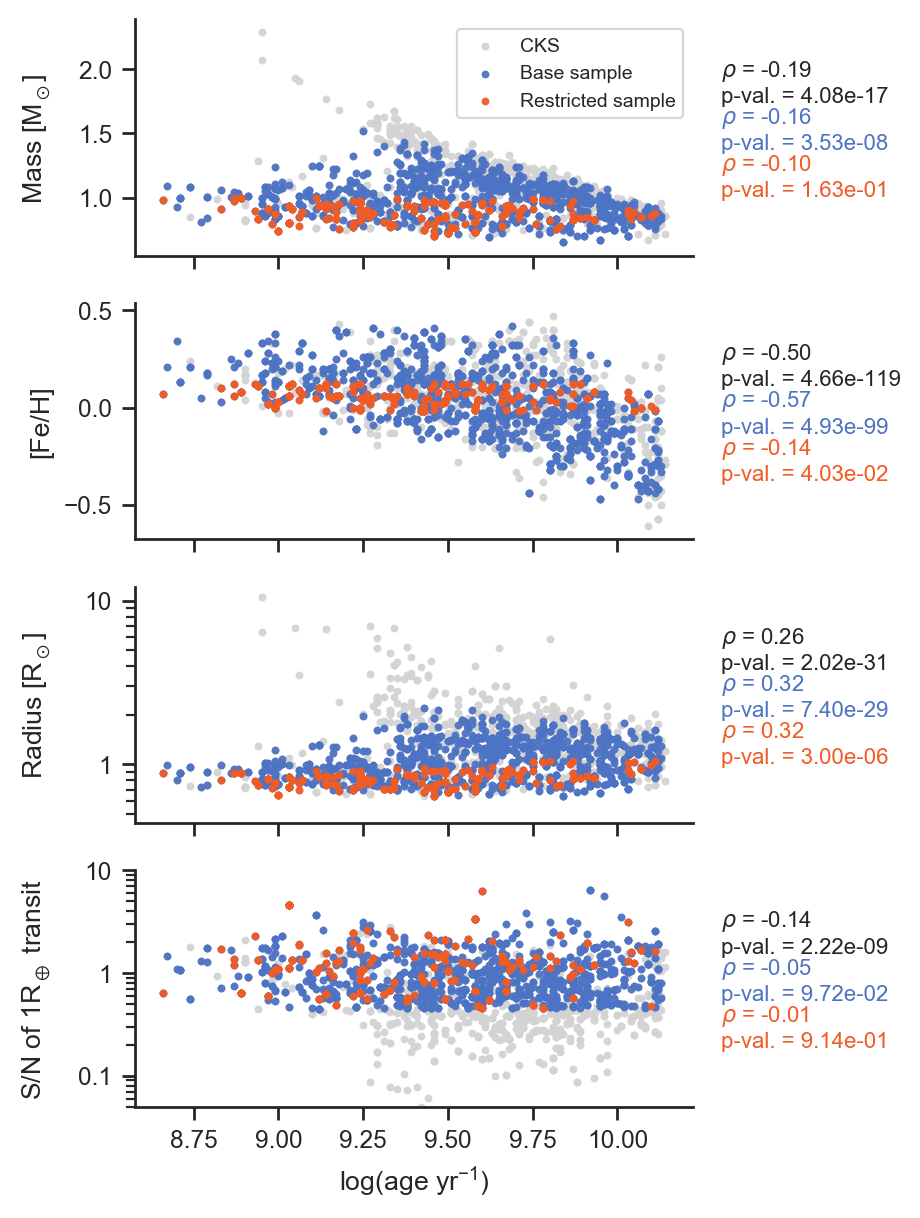

In [211]:
from scipy import stats

scatter_kwargs = {'alpha': 0.95, 's': 8, 'lw':0}

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(0.9*4,0.9*8), sharex=True)

#mask = m_fp & m_ms & m_P & m_snr
#mask = m_ms & m_fp & m_P & m_snr & m_r8 & m_RCF & m_ruwe & m_radiusprec & m_logaisonan & m_parallaxagree & m_rp
#m_r8 & m_RCF & m_ruwe 

age = cks['f18_logAiso']

variables = [cks['f18_Miso'], 
             cks['f18_[Fe/H]'],
             cks['f18_R'],
             cks['single_transit_snr']]


def f2str(n, sn=False):
    if sn==True:
        return "{:.2e}".format(n)
    else:
        return "{:.2f}".format(n)


text_kwargs = {'size':8}

for i,var in enumerate(variables):
    
    isfin = (np.isfinite(age)) & (np.isfinite(var))
    newm = isfin & base_sample
    newm2 = isfin & restricted_sample
    
    rho1, pval1 = stats.spearmanr(age[isfin], var[isfin])
    rho2, pval2 = stats.spearmanr(age[newm], var[newm])
    rho3, pval3 = stats.spearmanr(age[newm2], var[newm2])
    
    #rho1, pval1 = stats.kendalltau(age[isfin], var[isfin])
    #rho2, pval2 = stats.kendalltau(age[newm], var[newm])
    #rho3, pval3 = stats.kendalltau(age[newm2], var[newm2])

    #tau, p_value = stats.kendalltau(x1, x2)
       
    ax[i].scatter(age, var, color='lightgrey', **scatter_kwargs, label='CKS', rasterized=True)    
    ax[i].scatter(age[newm], var[newm], color=yng_color, **scatter_kwargs, label='Base sample', rasterized=True)
    ax[i].scatter(age[newm2], var[newm2], color=old_color, **scatter_kwargs, label='Restricted sample', rasterized=True)
    ax[i].text(1.05,0.65,r'$\rho$ = '+f2str(rho1)+'\np-val. = '+f2str(pval1, sn=True), transform=ax[i].transAxes, **text_kwargs)    
    ax[i].text(1.05,0.45,r'$\rho$ = '+f2str(rho2)+'\np-val. = '+f2str(pval2, sn=True), transform=ax[i].transAxes, color=yng_color, **text_kwargs)
    ax[i].text(1.05,0.25,r'$\rho$ = '+f2str(rho3)+'\np-val. = '+f2str(pval3, sn=True), transform=ax[i].transAxes, color=old_color, **text_kwargs)

    if i==0:
        ax[i].legend(loc='upper right', prop={'size':7})
    
    if i>=2:
        ax[i].semilogy()
        
ax[2].set_yticks([1,10])        
ax[2].set_yticklabels(['1','10'])        

ax[3].set_xlabel(r'log(age yr$^\mathregular{-1}$)') 
ax[3].set_yticks([0.1,1,10])
ax[3].set_yticklabels(['0.1','1','10'])
ax[3].set_ylim(0.05,10)

ax[0].set_ylabel(r'Mass [$\mathregular{M_\odot}$]')
ax[1].set_ylabel('[Fe/H]')
ax[2].set_ylabel(r'Radius [$\mathregular{R_\odot}$]')
ax[3].set_ylabel(r'S/N of 1$\mathregular{R_\oplus}$ transit')        

fig.align_ylabels(ax)
if fig_overwrite==True:
    plt.savefig('./figures/sample.pdf', dpi=300)
plt.show()

# print(len(age))
# print(len(age[base_sample]))
# print(len(age[restricted_sample]))

In [212]:
#Completeness maps
base_lt_1gyr = base_sample & (cks['f18_logAiso']<=9.)
base_gt_1gyr = base_sample & (cks['f18_logAiso']>9.)

base_1gyr3gyr = base_sample & (cks['f18_logAiso']>9.) & (cks['f18_logAiso']<=np.log10(3.0e9))

base_lt_3gyr = base_sample & (cks['f18_logAiso']<=np.log10(3.0e9))
base_gt_3gyr = base_sample & (cks['f18_logAiso']>np.log10(3.0e9))



new_df = pd.DataFrame({'cks_kepid': cks['dr25_kepid'][base_sample], 
                       'cks_mass': cks['f18_Miso'][base_sample],
                       'cks_radius': cks['f18_R'][base_sample],
                       'agegyr': 10.**cks['f18_logAiso'][base_sample]/1.0e9})
new_df = new_df.drop_duplicates(subset=['cks_kepid'])

new_df.to_csv('base_sample.csv', index=False)

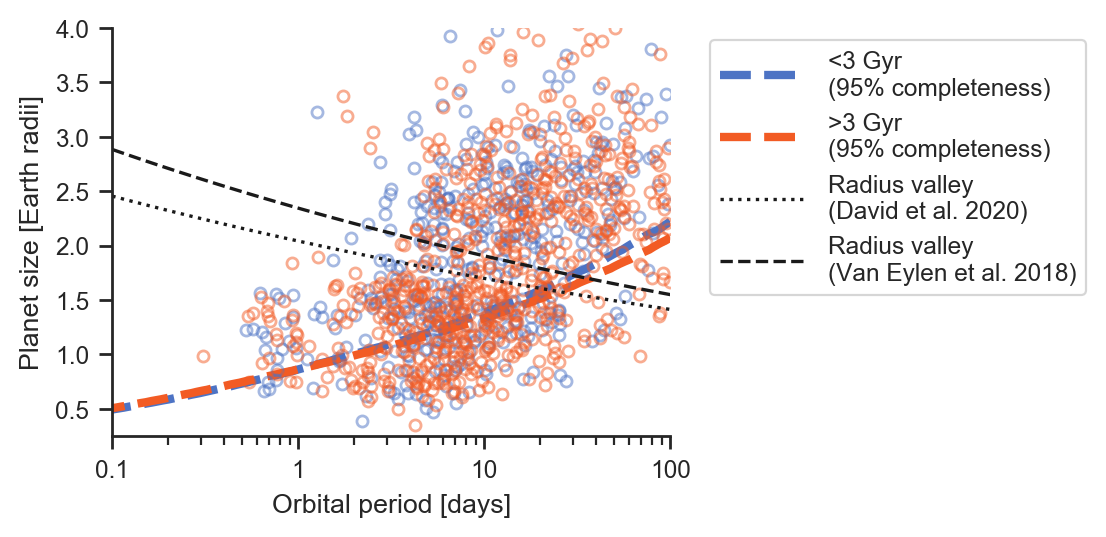

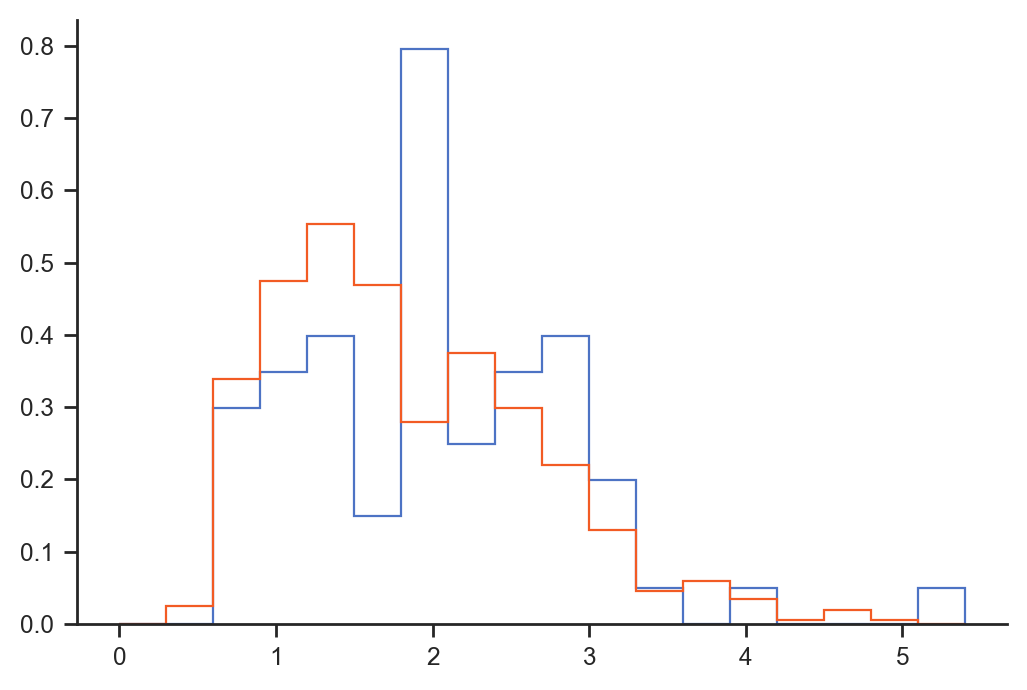

In [213]:
def Rp_valley(P, ref='D20'):
    if ref=='V18':
        a, b = -0.09, 0.37
    elif ref=='D20':
        a, b = -0.08, 0.31
    elif ref=='RO20':
        a, b = 0.0, np.log10(1.8)
    return 10**(a*np.log10(P) + b)

# To factor in uncertainties
# def Rp_valley(P, ref='D20'):
#     if ref=='V18':
#         a, b = np.random.normal(-0.09, 0.03), np.random.normal(0.37, 0.03)
#     elif ref=='D20':
#         a, b = np.random.normal(-0.08, 0.05), np.random.normal(0.31, 0.05)
#     elif ref=='RO20':
#         a, b = 0.0, np.log10(np.random.uniform(1.56,1.87))
#     return 10**(a*np.log10(P) + b)

# files = ['./cks_base_lt_1gyr_95pct.csv',
#          './cks_base_1gyr_3gyr_95pct.csv',
#         './cks_base_gt_3gyr_95pct.csv']

# ls = ['-', '--', ':']
# labels = ['<1 Gyr', '1-3 Gyr', '>3 Gyr']
# colors = ['r', 'b', 'g']

files = ['./cks_base_lt_3gyr_95pct.csv',
        './cks_base_gt_3gyr_95pct.csv']

ls = ['--', '--']
labels = ['<3 Gyr\n(95% completeness)', '>3 Gyr\n(95% completeness)']
colors = [yng_color, old_color]

for i,f in enumerate(files):
    df = pd.read_csv(f)
    plt.plot(df['p'], df['rp'], ls=ls[i], color=colors[i], label=labels[i], lw=3)
    
# files = ['./cks_base_lt_3gyr_50pct.csv',
#         './cks_base_gt_3gyr_50pct.csv']

# ls = [':', ':']
# labels = ['<3 Gyr (50% completeness)', '>3 Gyr (50% completeness)']
# colors = [yng_color, old_color]

# for i,f in enumerate(files):
#     df = pd.read_csv(f)
#     plt.plot(df['p'], df['rp'], ls=ls[i], color=colors[i], label=labels[i], lw=3)    
    

plt.semilogx()
p_grid = np.logspace(-1,2,100)
#plt.plot(cks['f18_P'][base_lt_1gyr],cks['f18_Rp'][base_lt_1gyr], 'o', mfc='None', color='r', ms=2)
#plt.plot(cks['f18_P'][base_1gyr3gyr],cks['f18_Rp'][base_1gyr3gyr], 'o', mfc='None', color='b', ms=2)
#plt.plot(cks['f18_P'][base_gt_3gyr],cks['f18_Rp'][base_gt_3gyr], 'o', mfc='None', color='g', ms=2)


plt.plot(cks['f18_P'][base_lt_3gyr],
         cks['f18_Rp'][base_lt_3gyr], 'o', mfc='None', color=yng_color, ms=4, alpha=0.5, rasterized=True)
plt.plot(cks['f18_P'][base_gt_3gyr],
         cks['f18_Rp'][base_gt_3gyr], 'o', mfc='None', color=old_color, ms=4, alpha=0.5, rasterized=True)

plt.plot(p_grid,Rp_valley(p_grid, ref='D20'), 'k:', label='Radius valley\n(David et al. 2020)')
plt.plot(p_grid,Rp_valley(p_grid, ref='V18'), 'k--', label='Radius valley\n(Van Eylen et al. 2018)')
plt.ylim(0.25,4)
plt.xlim(0.1,100)
plt.xticks([0.1,1,10,100],['0.1','1','10','100'])
plt.xlabel('Orbital period [days]')
plt.ylabel('Planet size [Earth radii]')
plt.legend(handlelength=3.6, bbox_to_anchor=(1.05,1))
plt.gcf().set_size_inches(0.9*4,0.9*3)
if fig_overwrite==True:
    plt.savefig('./figures/completeness.pdf', dpi=300)
plt.show()

plt.hist(cks['f18_Rp'][base_lt_1gyr], bins=np.arange(0,5.4,0.3), density=True, histtype='step', color=yng_color)
plt.hist(cks['f18_Rp'][base_gt_3gyr], bins=np.arange(0,5.4,0.3), density=True, histtype='step', color=old_color)
plt.show()

,f18_KOI,f18_P,f18_E_P,f18_e_P,f18_Rp/R*,f18_E_Rp/R*,f18_e_Rp/R*,f18_Rp,f18_E_Rp,f18_e_Rp,...,scale3,a5,loc5,scale5,f18_depth_ppm,single_transit_snr,Rcut,nplanets,Rp_valley,R_diff
0,K00001.01,2.470613,1.900000e-08,1.900000e-08,0.123851,0.000025,0.000076,14.141,0.331,0.331,...,0.196824,-0.844107,9.817946,0.165594,15339.070201,2.970791,2.093577,1,1.899221,12.241779
1,K00002.01,2.204735,3.800000e-08,3.800000e-08,0.075408,0.000008,0.000007,16.250,0.349,0.349,...,0.067507,-1.059536,9.278683,0.055756,5686.366464,0.541455,2.889940,1,1.916600,14.333400
2,K00006.01,1.334104,7.070000e-07,7.070000e-07,0.294016,0.103683,0.209459,41.936,22.239,22.239,...,0.278910,-3.731076,9.472594,0.270625,86445.408256,1.012527,2.744381,1,1.995193,39.940807
3,K00007.01,3.213669,1.122000e-06,1.122000e-06,0.024735,0.000141,0.000076,4.076,0.107,0.107,...,0.116269,0.030719,9.789814,0.087285,611.820225,0.836632,2.102164,1,1.859687,2.216313
4,K00008.01,1.160153,4.270000e-07,4.270000e-07,0.018559,0.000246,0.001678,1.896,0.110,0.110,...,0.653710,-2.445676,9.518279,0.588301,344.436481,1.542847,2.172145,1,2.017617,-0.121617


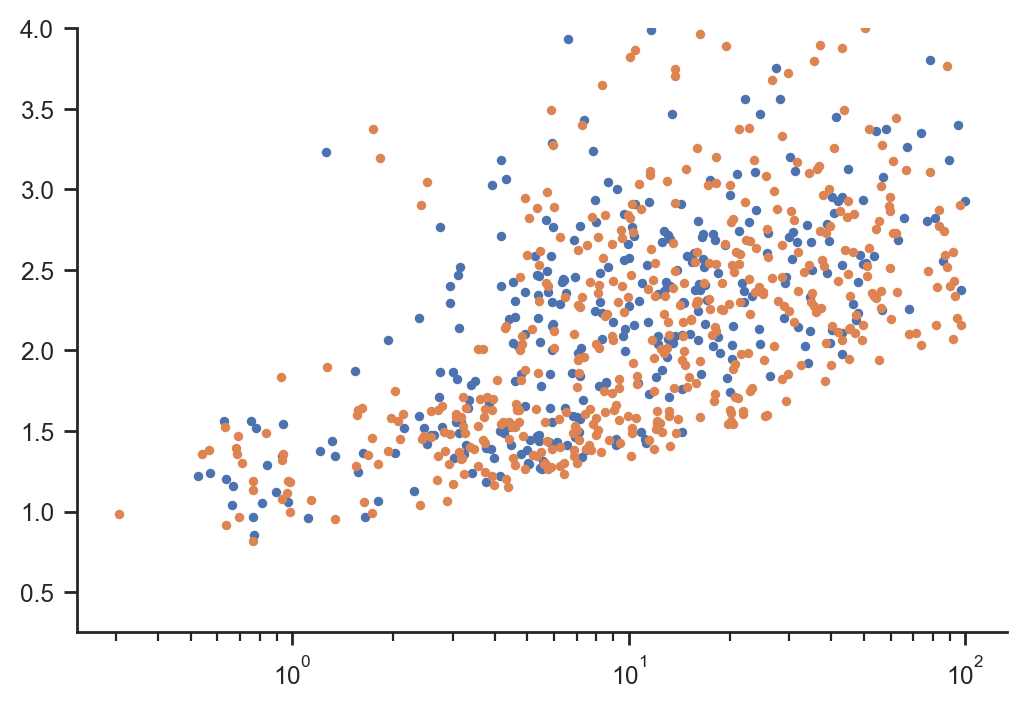

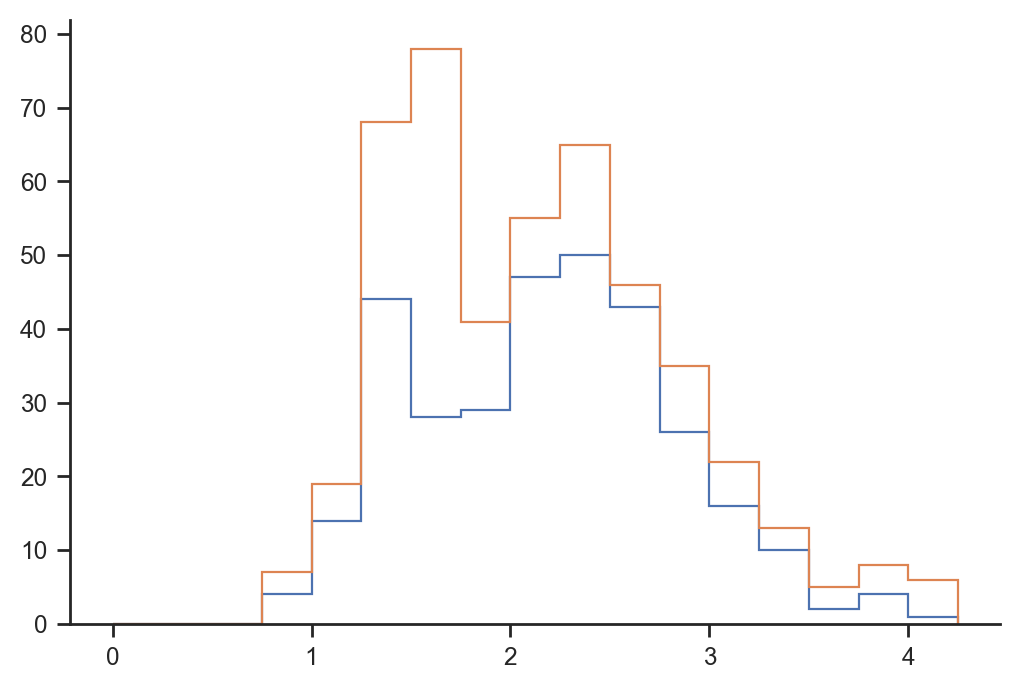

In [214]:
from scipy.interpolate import interp1d

#x = np.linspace(0, 10, num=11, endpoint=True)
#y = np.cos(-x**2/9.0)
#f = interp1d(x, y)
#f2 = interp1d(x, y, kind='cubic')


df1 = pd.read_csv('./cks_base_lt_3gyr_95pct.csv')
df2 = pd.read_csv('./cks_base_gt_3gyr_95pct.csv')


f1 = interp1d(df1['p'][np.argsort(df1['p'])], df1['rp'][np.argsort(df1['p'])], kind='cubic', fill_value="extrapolate")
f2 = interp1d(df2['p'][np.argsort(df2['p'])], df2['rp'][np.argsort(df2['p'])], kind='cubic', fill_value="extrapolate")
#f3 = interp1d(df2['p'][np.argsort(df2['p'])], np.mean([df1['rp'][np.argsort(df1['p'])],
#                                                       df2['rp'][np.argsort(df2['p'])]],axis=1), kind='cubic', fill_value="extrapolate")

# plt.plot(df1['p'], df1['rp'], '.')
# plt.plot(df1['p'], f1(df1['p']), '-')
# plt.plot(df2['p'], df2['rp'], '.')
# plt.plot(df2['p'], f2(df2['p']), '-')
# plt.plot(df2['p'], f3(df2['p']), ':')
# plt.semilogx()
# plt.show()


tmp1 = base_lt_3gyr & (cks['f18_Rp']>f1(cks['f18_P']))
tmp2 = base_gt_3gyr & (cks['f18_Rp']>f2(cks['f18_P']))


plt.plot(cks['f18_P'][tmp1], cks['f18_Rp'][tmp1], '.')
plt.plot(cks['f18_P'][tmp2], cks['f18_Rp'][tmp2], '.')
plt.semilogx()
plt.ylim(0.25,4)
plt.show()

plt.hist(cks['f18_Rp'][tmp1], bins=np.arange(0,4.5,0.25), histtype='step', label='young')
plt.hist(cks['f18_Rp'][tmp2], bins=np.arange(0,4.5,0.25), histtype='step', label='old')

#plt.hist(cks['f18_Rp'][tmp1], bins=np.arange(0,1.8*3,1.8), histtype='step', label='young')
#plt.hist(cks['f18_Rp'][tmp2], bins=np.arange(0,1.8*3,1.8), histtype='step', label='old')
plt.show()



# _hist1, _bin_edges = np.histogram(cks['f18_Rp'][tmp1], bins=[0,1.8,5])
# _hist2, _bin_edges = np.histogram(cks['f18_Rp'][tmp2], bins=[0,1.8,5])
# plt.step(_bin_edges, _hist1/_hist1[1], where='pre')
# plt.show()

# print(_bin_edges)
# print(_hist1[0]/_hist1[1])
# print(_hist2[0]/_hist2[1])


x1 = cks['f18_Rp'][tmp1]
x2 = cks['f18_Rp'][tmp2]

nboot = 1000
hist1 = []
hist2 = []

np.random.seed(2020)

for i in range(nboot):
    
    arg1 = np.random.choice(len(x1), np.min([len(x1),len(x2)]), replace=True)
    arg2 = np.random.choice(len(x2), np.min([len(x1),len(x2)]), replace=True)
    
    #x1sim = np.random.normal(x1, x1err)
    #x2sim = np.random.normal(x2, x2err)
    x1sim = np.array(x1)
    x2sim = np.array(x2)
    
    _hist1, bin_edges = np.histogram(x1sim[arg1], bins=[0,1.8,5], density=True)
    _hist2, bin_edges = np.histogram(x2sim[arg2], bins=[0,1.8,5], density=True)
    
    hist1.append(_hist1)
    hist2.append(_hist2)
    
    
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
hist1_e = np.median(hist1, axis=0)-np.percentile(hist1, 16., axis=0)
hist1_E = np.percentile(hist1, 84., axis=0)-np.median(hist1, axis=0)

hist2_e = np.median(hist2, axis=0)-np.percentile(hist2, 16., axis=0)
hist2_E = np.percentile(hist2, 84., axis=0)-np.median(hist2, axis=0)

hist_kwargs = {'alpha':0.75, 'lw':2.5}


# med1 = np.median(hist1, axis=0)
# med1 += med1[0]
# med2 = np.median(hist2, axis=0)
# med2 += med2[0]

# plt.bar(bin_edges[:-1], med1, width=1.8, color="None")
# plt.bar(bin_edges[:-1], med2, width=1.8, color="None")


# plt.plot(bin_centers, np.median(hist1, axis=0), drawstyle='steps-mid', color=yng_color, label=r'Age < 3 Gyr', **hist_kwargs)
# plt.errorbar(bin_centers, np.median(hist1, axis=0), yerr=[hist1_e, hist1_E], fmt='.', color=yng_color, **hist_kwargs)
# plt.plot(bin_centers, np.median(hist2, axis=0), drawstyle='steps-mid', color=old_color, label=r'Age > 3 Gyr', **hist_kwargs)
# plt.errorbar(bin_centers, np.median(hist2, axis=0), yerr=[hist2_e, hist2_E], fmt='.', color=old_color, **hist_kwargs)
# plt.xlabel('Planet size [Earth radii]')
# plt.ylabel('Probability density')
# plt.legend()
# plt.xticks(np.arange(0.5,5,0.5))
# plt.xlim(0.5,4.5)
# plt.ylim(0,1)
# sns.despine(offset=2, trim=True)

In [215]:
plt.errorbar(cks['f18_logAiso'][base_sample], cks['R_diff'][base_sample], 
             xerr=[cks['f18_e_logAiso'][base_sample],cks['f18_E_logAiso'][base_sample]],
             yerr=[cks['f18_e_Rp'][base_sample],cks['f18_E_Rp'][base_sample]], fmt='o', alpha=0.25, lw=0.5, ecolor='lightgrey')
plt.ylim(-2,2.5)
plt.show()

KeyError: 'R_diff'

8.5
9.0
9.5
10.0


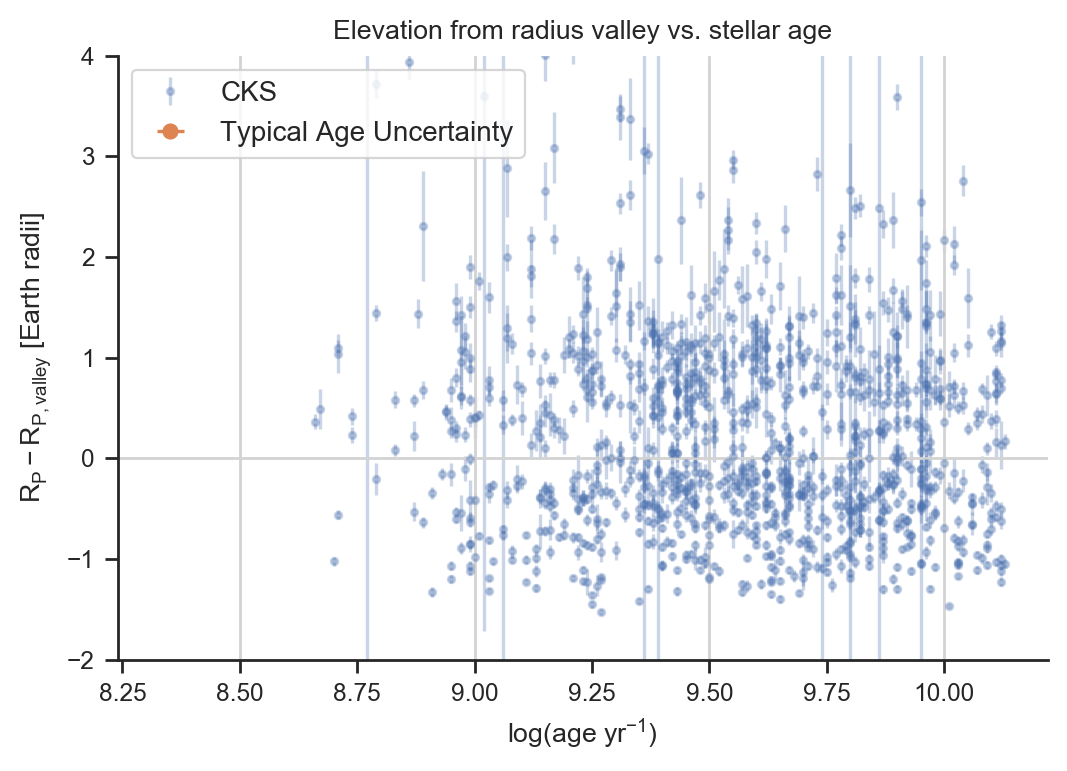

In [216]:
cks["Rp_valley"] = Rp_valley(cks['f18_P'], ref='D20')
cks['R_diff'] = cks["f18_Rp"] - cks["Rp_valley"]

#short_period = ful_planet["P"] < 30
#long_period = ful_planet["P"] > 30
#plt.scatter(ful_planet["logAiso"][short_period],ful_planet["R_diff"][short_period],s = 8,alpha = 0.3, label = "Short Period")
plt.errorbar(cks["f18_logAiso"][base_sample],cks["R_diff"][base_sample], yerr = [cks['f18_e_Rp'][base_sample], cks['f18_E_Rp'][base_sample]], fmt = '.',alpha = 0.3, label = 'CKS')
plt.errorbar(8.5, -2.2, xerr=np.median(cks['f18_E_logAiso'][base_sample]), fmt='o', label = 'Typical Age Uncertainty') #typical uncertainty in stellar age
plt.legend(prop = {'size': 10}, loc = 'upper left')
plt.xlabel(r"log(age yr$^\mathregular{-1}$)")
plt.ylabel(r"$\mathregular{R_P - R_{P,valley}}$ [Earth radii]")
plt.title('Elevation from radius valley vs. stellar age')
plt.ylim(-2,4)
plt.axhline(0, color = 'lightgrey', lw = 1)

_bins = np.arange(8.5,10.5,0.5)
for b in _bins:
    plt.axvline(b, color = 'lightgrey', lw = 1)
    print(b)
#plt.savefig("rp-rpvalley.jpg",bbox_inches='tight',dpi = 300)

In [217]:
from scipy import stats

# idx = np.random.choice(len(cks))

# #tmp = stats.skewnorm.rvs(a=cks['a3'].iloc[idx], loc=cks['loc3'].iloc[idx], scale=cks['scale3'].iloc[idx], size=4000)
# #tmp2 = stats.skewnorm.rvs(a=cks['a5'].iloc[idx], loc=cks['loc5'].iloc[idx], scale=cks['scale5'].iloc[idx], size=4000)
# # plt.hist(tmp, bins=50, histtype='step', label='3 pt')
# # plt.hist(tmp2, bins=50, histtype='step', label='5 pt')
# # plt.legend()
# # plt.show()


# #print(stats.skewnorm.rvs(a=cks['a3'].iloc[0:2], loc=cks['loc3'].iloc[0:2], scale=cks['scale3'].iloc[0:2]))

# #print(stats.skewnorm.rvs(a=cks['a3'].iloc[0:2], loc=cks['loc3'].iloc[0:2], scale=cks['scale3'].iloc[0:2]))
# print(cks['f18_logAiso'].iloc[0:2])

# # tmp = np.array([stats.skewnorm.rvs(a=cks['a3'].iloc[0:2], 
# #                                    loc=cks['loc3'].iloc[0:2], 
# #                                    scale=cks['scale3'].iloc[0:2]) for n in range(3)])


# age_a3, age_loc3, age_scale3 = cks['a3'][base_sample], cks['loc3'][base_sample], cks['scale3'][base_sample]
# tmp = stats.skewnorm.rvs(a=age_a3, loc=age_loc3, scale=age_scale3)
# print(tmp)

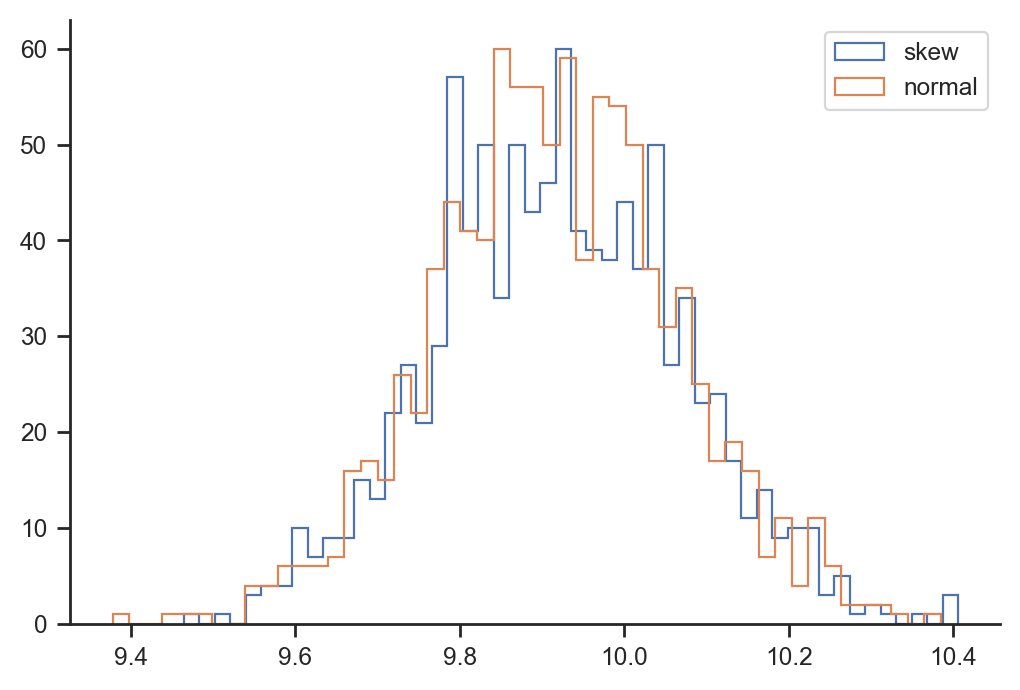

In [162]:
# idx = np.random.choice(len(cks))

# age_a3, age_loc3, age_scale3 = cks['a3'], cks['loc3'], cks['scale3']

# tmp = stats.skewnorm.rvs(a=0, loc=cks['f18_logAiso'].iloc[idx], scale=cks['f18_E_logAiso'].iloc[idx], size=1000)
# plt.hist(tmp, bins=50, histtype='step', label='skew')
# plt.hist(np.random.normal(cks['f18_logAiso'].iloc[idx], cks['f18_E_logAiso'].iloc[idx], size=1000), bins=50, histtype='step', label='normal')
# plt.legend()
# plt.show()

In [224]:
def new_fn_speed(cks, m, 
                 _binwidth=0.125, 
                 nsamples=10000, 
                 age_ref='cks', 
                 age_dist='normal', 
                 rv_ref='D20'):
    
    #bin_centers = np.linspace(8.25,10.25,50)
    bin_centers = np.linspace(8.5,10,50)
    ratio = np.zeros([len(bin_centers), nsamples])
    
    if age_ref == 'cks':
        age_med, age_err_lo, age_err_hi = cks['f18_logAiso'], cks['f18_e_logAiso'], cks['f18_E_logAiso']
        age_a3, age_loc3, age_scale3 = cks['a3'], cks['loc3'], cks['scale3']
        age_a5, age_loc5, age_scale5 = cks['a5'], cks['loc5'], cks['scale5']
        
        #shape_nan = np.isnan(age_a3)
        #age_a3[shape_nan] = 0.0
        #age_loc3[shape_nan] = age_med[shape_nan]
        #age_scale3[shape_nan] = age_err_lo[shape_nan] ########
        
    elif age_ref == 'berger':
        age_med, age_err_lo, age_err_hi = cks['b20_log10_iso_age'], cks['b20_e_log10_iso_age'], cks['b20_E_log10_iso_age']     
        
        
    if age_dist == 'normal':
        mc_age = np.array([np.random.normal(age_med, np.max([age_err_lo, age_err_hi], 
                                                            axis=0)) for n in range(nsamples)])
    elif age_dist == 'uniform':
        mc_age = np.array([np.random.uniform(age_med-age_err_lo, age_med+age_err_hi) for n in range(nsamples)])
        
    elif age_dist == 'skewnormal':
        #mc_age = np.array([stats.skewnorm.rvs(a=age_a3, loc=age_loc3, scale=age_scale3) for n in range(nsamples)])
        mc_age = np.array([stats.skewnorm.rvs(a=age_a5, loc=age_loc5, scale=age_scale5) for n in range(nsamples)])
        

    m_duplic = np.repeat([m], nsamples, axis=0)
    
    p_duplic = np.repeat([cks['f18_P']], nsamples, axis=0)
    
    Rp_duplic = np.repeat([cks['f18_Rp']], nsamples, axis=0)
    ERp_dupl =  np.repeat([cks['f18_E_Rp']], nsamples, axis=0)
    eRp_dupl =  np.repeat([cks['f18_e_Rp']], nsamples, axis=0)
    
    mc_rp = np.random.normal(Rp_duplic, 
                                 np.max([ERp_dupl,eRp_dupl], axis=0)) - Rp_valley(p_duplic, ref=rv_ref)
    
    #for i in tqdm(range(len(bin_centers))):
    for i in range(len(bin_centers)):          
        mask = m_duplic & (mc_age>=bin_centers[i]-_binwidth) & (mc_age<bin_centers[i]+_binwidth)
   
        for j in range(nsamples):
            mc_rp_ = mc_rp[j][mask[j]]
            
            try:
                ratio[i,j] = len(mc_rp_[mc_rp_<0])/len(mc_rp_[mc_rp_>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    
    return bin_centers, ratio

In [96]:
#v18, d20, flat line (rogers & owen)
#3sigma above/below

m = base_sample & (cks['f18_Teff']>5500)
#m = m_fp & m_P & m_snr & m_logaisonan & m_ms & m_radiusprec & (cks['f18_Teff']>5500) #& (abs(cks['f18_[Fe/H]']-np.nanmedian(cks['f18_[Fe/H]']))<0.15) & (cks['f18_R']<1.1)

#m_ageprec = np.all(np.array([cks['f18_e_logAiso'], cks['f18_E_logAiso']])<0.5, axis=0)
    
#m = m_fp & m_ms & m_P & m_snr & m_rp #& m_ageprec
    
bin_centers, _ratio = new_fn_speed(cks, m=m, 
                              _binwidth=0.5, age_ref='cks', age_dist='normal', rv_ref='D20', nsamples=1000)


#print(np.min(cks['f18_Teff'][m]), np.max(cks['f18_Teff'][m]))

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


[]

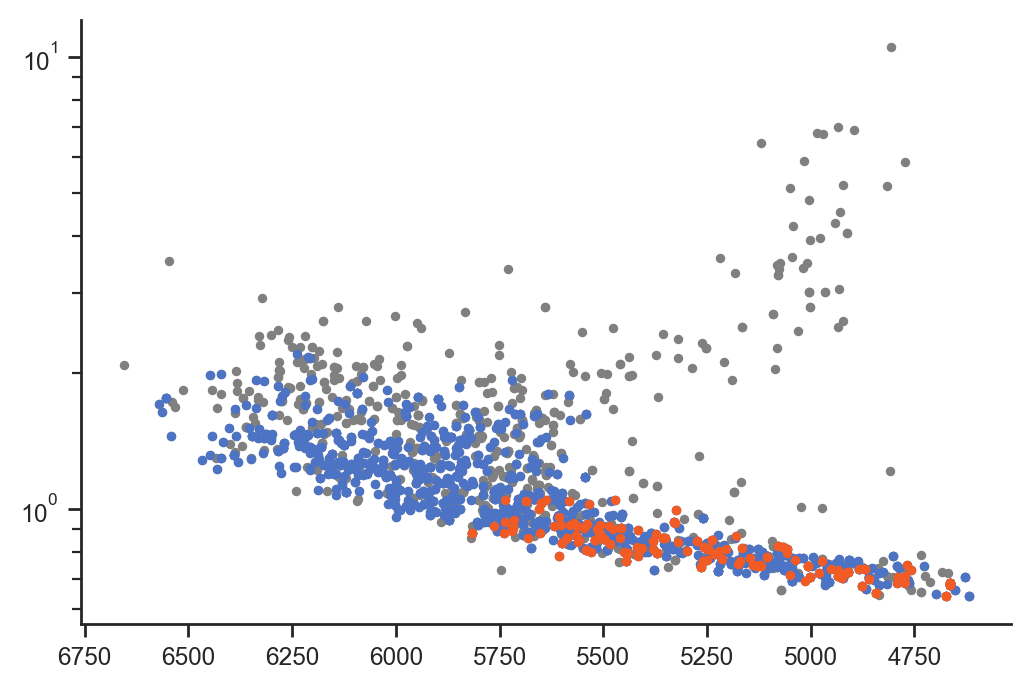

In [219]:
#m = m_fp & m_P & m_snr & m_Rpmin #m_ms
plt.plot(cks['f18_Teff'], cks['f18_R'],'.', color='grey')
plt.plot(cks['f18_Teff'][base_sample], cks['f18_R'][base_sample],'.', color=yng_color)
plt.plot(cks['f18_Teff'][restricted_sample], cks['f18_R'][restricted_sample],'.', color=old_color)
plt.gca().invert_xaxis()
plt.semilogy()

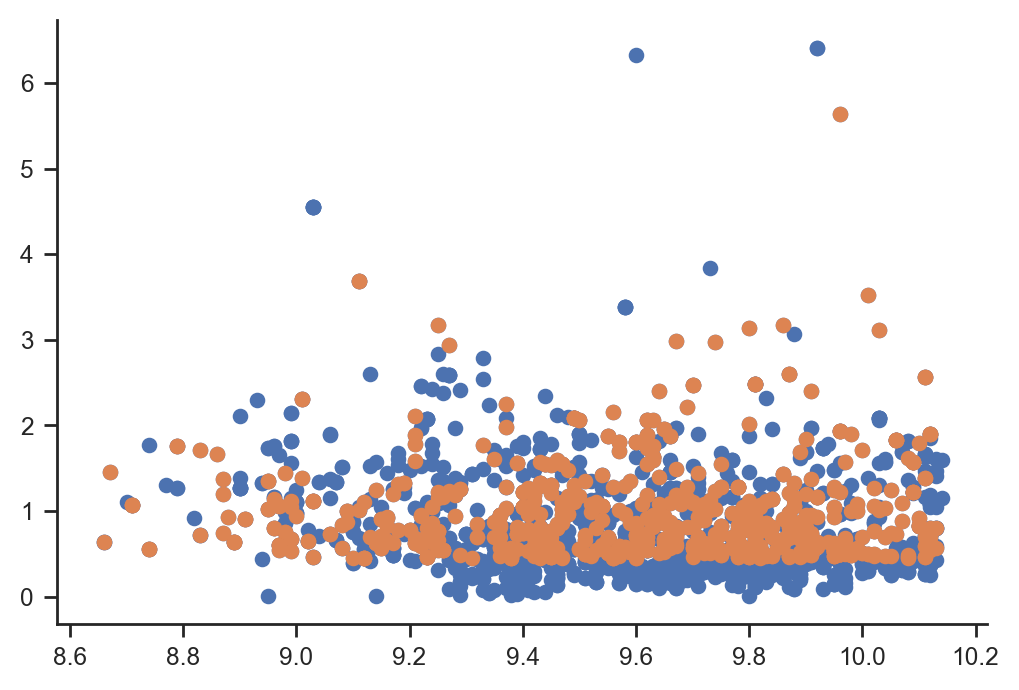

In [98]:
tmp=base_sample&(cks['f18_Teff']>5500)

plt.scatter(cks['f18_logAiso'], cks['single_transit_snr'])
plt.scatter(cks['f18_logAiso'][tmp], cks['single_transit_snr'][tmp])
plt.show()

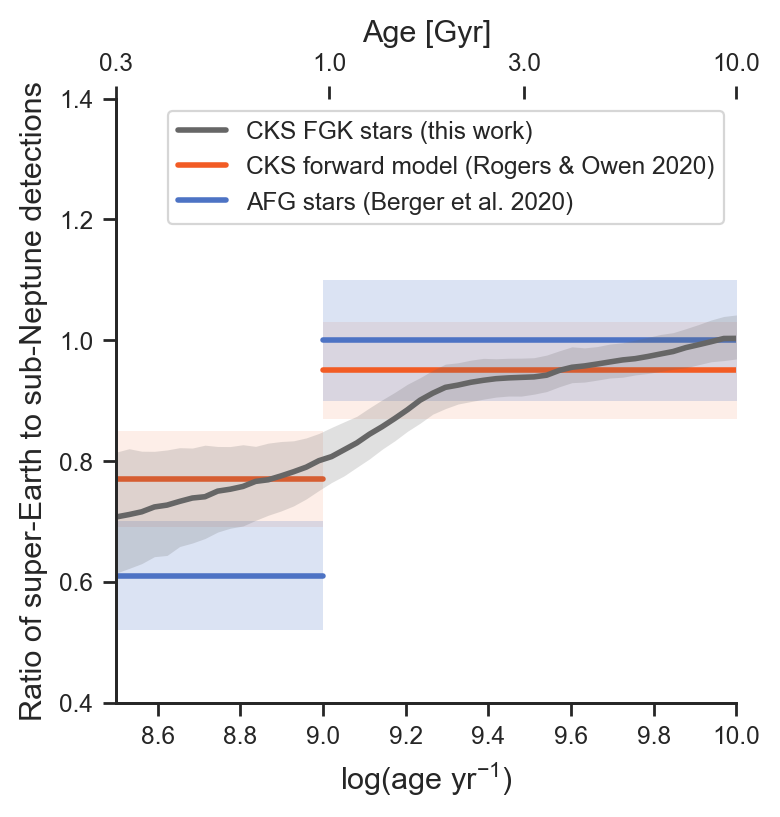

SE/SN ratio (<1 Gyr) =  0.7521553938260132 0.07754048338772988
SE/SN ratio (>1 Gyr) =  0.9337155910680379 0.06308307388212993
-2.341489107491882 sigma
SE/SN ratio (<3 Gyr) =  0.816288617777901 0.09732268155433861
SE/SN ratio (>3 Gyr) =  0.9710011350774805 0.03693540023222748
-1.5896861330644516


In [225]:
#base_sample = m_fp & m_ms & (cks['single_transit_snr']>0.45) & m_P & m_rp & m_misonan & m_logaisonan & m_parallaxagree & m_radiusprec
#base_sample = m_fp&m_ms&m_P&(cks['single_transit_snr']>0.45)&m_parallaxagree & m_misonan & m_logaisonan
#base_sample = m_fp&m_ms&m_P&(cks['single_transit_snr']>0.45)&m_parallaxagree & m_misonan & m_logaisonan
#base_sample = m_fp&m_ms&m_P&(cks['single_transit_snr']>0.5)&m_parallaxagree & m_misonan & m_logaisonan

bin_centers, _ratio = new_fn_speed(cks, m=base_sample, 
                                _binwidth=0.5, age_ref='cks', age_dist='skewnormal', rv_ref='D20', nsamples=1000)

bin_centers, _ratio_hot = new_fn_speed(cks, m=base_sample&(cks['f18_Teff']>5500), 
                              _binwidth=0.5, age_ref='cks', age_dist='skewnormal', rv_ref='D20', nsamples=1000)

# bin_centers, _ratio_cool = new_fn_speed(cks, m=restricted_sample, 
#                               _binwidth=0.5, age_ref='cks', age_dist='normal', rv_ref='D20', nsamples=1000)


#clr = '#d4689f'
clr = '#666666'

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twiny()


ax.plot(bin_centers, np.nanmedian(_ratio, axis=1), color=clr, label='CKS FGK stars (this work)', lw=2, zorder=999)

#ax.plot(bin_centers, np.nanmedian(_ratio_hot, axis=1), color=clr, label='CKS FG stars (this work)', ls='--', lw=2, zorder=999)
#ax.plot(bin_centers, np.nanmedian(_ratio_cool, axis=1), color=clr, label='CKS cool stars (this work)', ls=':', lw=2, zorder=999)

#for ci in [68.3,95.4,99.7]:
for ci in [68.3]:
    ax.fill_between(bin_centers, 
                 np.nanpercentile(_ratio, 50.-0.5*ci, axis=1), 
                 np.nanpercentile(_ratio, 50.+0.5*ci, axis=1), 
                 alpha=0.2, color=clr, lw=0, zorder=999)
    
#     ax.fill_between(bin_centers, 
#                  np.nanpercentile(_ratio_hot, 50.-0.5*ci, axis=1), 
#                  np.nanpercentile(_ratio_hot, 50.+0.5*ci, axis=1), 
#                  alpha=0.2, color=clr, lw=0, zorder=999)    



ax.set_xlabel(r'log(age yr$^\mathregular{-1}$)', size=11)
ax.set_ylabel('Ratio of super-Earth to sub-Neptune detections', size=11)


#Rogers & Owen 2020
#ro_color = '#597cde'
ro_color = '#d4689f'

ax.plot([8.25,9],[0.77,0.77], old_color, label='CKS forward model (Rogers & Owen 2020)', lw=2)
ax.fill_between([8.25,9],0.77-0.08,0.77+0.08, alpha=0.1, color=old_color, lw=0)
ax.plot([9,10.25],[0.95,0.95], old_color, lw=2)
ax.fill_between([9,10.25],0.95-0.08,0.95+0.08, alpha=0.1, color=old_color, lw=0)


#Berger et al. 2020
#be_color = '#666666'
#be_color = '#e3933d'
#be_color='#d4689f'
be_color = '#597cde'

ax.plot([8.25,9],[0.61,0.61], color=yng_color, label='AFG stars (Berger et al. 2020)', lw=2)
ax.fill_between([8.25,9],0.61-0.09,0.61+0.09, alpha=0.2, color=yng_color, lw=0)
ax.plot([9,10.25],[1,1], color=yng_color, lw=2)
ax.fill_between([9,10.25],1-0.1,1+0.1, alpha=0.2, color=yng_color, lw=0)

#Fulton et al. 2017 Occurrence ratio
#plt.fill_between([8.25,10.25],0.8-0.2,0.8+0.2, alpha=0.2, color='g', lw=0)

ax.set_xlim(bin_centers.min(), bin_centers.max())
ax.set_ylim(0.4,1.4)
#plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', frameon=False)
ax.legend()


new_tick_locations = np.log10([3e8,1e9,3e9,1e10])

def tick_function(X):
    V = 10.**X/(1.0e9)
    return ["%.1f" % z for z in V]

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Age [Gyr]", size=11)

plt.gcf().set_size_inches(4,4)
if fig_overwrite==True:
    plt.savefig('./figures/ratio.pdf')
    #plt.savefig('./figures/ratio-hot.pdf')
plt.show()

print('SE/SN ratio (<1 Gyr) = ', np.mean(_ratio[bin_centers<=9]), np.std(_ratio[bin_centers<=9]))
print('SE/SN ratio (>1 Gyr) = ', np.mean(_ratio[bin_centers>9]), np.std(_ratio[bin_centers>9]))
#_err = np.sqrt(np.std(_ratio[bin_centers<=9])**2 + np.std(_ratio[bin_centers>9])**2)
_err = np.max([np.std(_ratio[bin_centers<=9]), np.std(_ratio[bin_centers>9])])
print((np.mean(_ratio[bin_centers<=9])-np.mean(_ratio[bin_centers>9]))/_err, 'sigma')

print('SE/SN ratio (<3 Gyr) = ', np.mean(_ratio[bin_centers<=np.log10(3e9)]), np.std(_ratio[bin_centers<=np.log10(3e9)]))
print('SE/SN ratio (>3 Gyr) = ', np.mean(_ratio[bin_centers>np.log10(3e9)]), np.std(_ratio[bin_centers>np.log10(3e9)]))
#_err = np.sqrt(np.std(_ratio[bin_centers<=np.log10(3e9)])**2 + np.std(_ratio[bin_centers>np.log10(3e9)])**2)
_err = np.max([np.std(_ratio[bin_centers<=np.log10(3e9)]), np.std(_ratio[bin_centers>np.log10(3e9)])])
print((np.mean(_ratio[bin_centers<=np.log10(3e9)])-np.mean(_ratio[bin_centers>np.log10(3e9)]))/_err)

In [100]:
print(len(cks[base_lt_1gyr]))

70


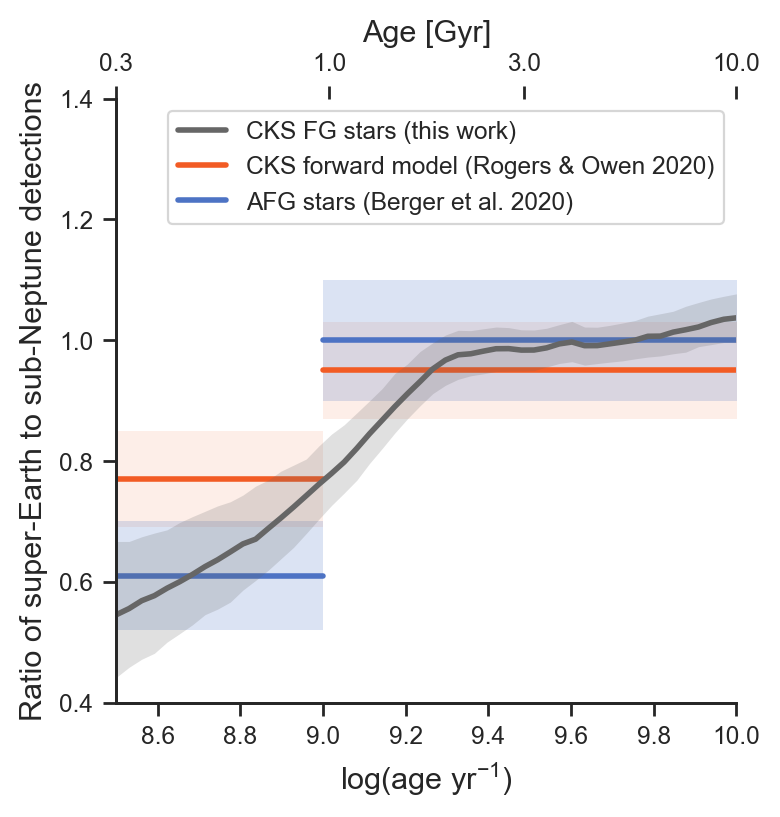

SE/SN ratio (<1 Gyr) =  0.6466241397859323 0.10838139800128894
SE/SN ratio (>1 Gyr) =  0.9631564084219273 0.07769947572339633
-2.373594295670035 sigma
SE/SN ratio (<3 Gyr) =  0.7715464334179826 0.16482599597784053
SE/SN ratio (>3 Gyr) =  1.0048492213838334 0.03850064894115025
-1.4154489804946568


In [226]:
bin_centers, _ratio = new_fn_speed(cks, m=base_sample&(cks['f18_Teff']>5500), 
                              _binwidth=0.5, age_ref='cks', age_dist='skewnormal', rv_ref='D20', nsamples=1000)


#clr = '#d4689f'
clr = '#666666'

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twiny()


#ax.plot(bin_centers, np.nanmedian(_ratio, axis=1), color=clr, label='CKS Sun-like stars (this work)', lw=2, zorder=999)
#ax.plot(bin_centers, np.nanmedian(_ratio, axis=1), color=clr, label='CKS Teff > 5500 K (this work)', lw=2, zorder=999)

#ax.plot(bin_centers, np.nanmedian(_ratio, axis=1), color=clr, label='CKS FGK stars (this work)', lw=2, zorder=999)
ax.plot(bin_centers, np.nanmedian(_ratio, axis=1), color=clr, label='CKS FG stars (this work)', lw=2, zorder=999)


#ax.plot(bin_centers, np.nanmedian(_ratio_hot, axis=1), color=clr, label='CKS FG stars (this work)', ls='--', lw=2, zorder=999)
#ax.plot(bin_centers, np.nanmedian(_ratio_cool, axis=1), color=clr, label='CKS cool stars (this work)', ls=':', lw=2, zorder=999)

#for ci in [68.3,95.4,99.7]:
for ci in [68.3]:
    ax.fill_between(bin_centers, 
                 np.nanpercentile(_ratio, 50.-0.5*ci, axis=1), 
                 np.nanpercentile(_ratio, 50.+0.5*ci, axis=1), 
                 alpha=0.2, color=clr, lw=0, zorder=999)
    
#     ax.fill_between(bin_centers, 
#                  np.nanpercentile(_ratio_hot, 50.-0.5*ci, axis=1), 
#                  np.nanpercentile(_ratio_hot, 50.+0.5*ci, axis=1), 
#                  alpha=0.2, color=clr, lw=0, zorder=999)    



ax.set_xlabel(r'log(age yr$^\mathregular{-1}$)', size=11)
ax.set_ylabel('Ratio of super-Earth to sub-Neptune detections', size=11)


#Rogers & Owen 2020
#ro_color = '#597cde'
ro_color = '#d4689f'

ax.plot([8.25,9],[0.77,0.77], old_color, label='CKS forward model (Rogers & Owen 2020)', lw=2)
ax.fill_between([8.25,9],0.77-0.08,0.77+0.08, alpha=0.1, color=old_color, lw=0)
ax.plot([9,10.25],[0.95,0.95], old_color, lw=2)
ax.fill_between([9,10.25],0.95-0.08,0.95+0.08, alpha=0.1, color=old_color, lw=0)


#Berger et al. 2020
#be_color = '#666666'
#be_color = '#e3933d'
#be_color='#d4689f'
be_color = '#597cde'

ax.plot([8.25,9],[0.61,0.61], color=yng_color, label='AFG stars (Berger et al. 2020)', lw=2)
ax.fill_between([8.25,9],0.61-0.09,0.61+0.09, alpha=0.2, color=yng_color, lw=0)
ax.plot([9,10.25],[1,1], color=yng_color, lw=2)
ax.fill_between([9,10.25],1-0.1,1+0.1, alpha=0.2, color=yng_color, lw=0)

#Fulton et al. 2017 Occurrence ratio
#plt.fill_between([8.25,10.25],0.8-0.2,0.8+0.2, alpha=0.2, color='g', lw=0)

ax.set_xlim(bin_centers.min(), bin_centers.max())
ax.set_ylim(0.4,1.4)
#plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', frameon=False)
ax.legend()


new_tick_locations = np.log10([3e8,1e9,3e9,1e10])

def tick_function(X):
    V = 10.**X/(1.0e9)
    return ["%.1f" % z for z in V]

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Age [Gyr]", size=11)

plt.gcf().set_size_inches(4,4)
if fig_overwrite==True:
    plt.savefig('./figures/ratio-hot.pdf')
plt.show()

print('SE/SN ratio (<1 Gyr) = ', np.mean(_ratio[bin_centers<=9]), np.std(_ratio[bin_centers<=9]))
print('SE/SN ratio (>1 Gyr) = ', np.mean(_ratio[bin_centers>9]), np.std(_ratio[bin_centers>9]))
_err = np.sqrt(np.std(_ratio[bin_centers<=9])**2 + np.std(_ratio[bin_centers>9])**2)
#_err = np.max([np.std(_ratio[bin_centers<=9]), np.std(_ratio[bin_centers>9])])
print((np.mean(_ratio[bin_centers<=9])-np.mean(_ratio[bin_centers>9]))/_err, 'sigma')

print('SE/SN ratio (<3 Gyr) = ', np.mean(_ratio[bin_centers<=np.log10(3e9)]), np.std(_ratio[bin_centers<=np.log10(3e9)]))
print('SE/SN ratio (>3 Gyr) = ', np.mean(_ratio[bin_centers>np.log10(3e9)]), np.std(_ratio[bin_centers>np.log10(3e9)]))
#_err = np.sqrt(np.std(_ratio[bin_centers<=np.log10(3e9)])**2 + np.std(_ratio[bin_centers>np.log10(3e9)])**2)
_err = np.max([np.std(_ratio[bin_centers<=np.log10(3e9)]), np.std(_ratio[bin_centers>np.log10(3e9)])])
print((np.mean(_ratio[bin_centers<=np.log10(3e9)])-np.mean(_ratio[bin_centers>np.log10(3e9)]))/_err)

In [ ]:
SE/SN ratio (<1 Gyr) =  0.6524917692916888 0.10963614446137984
SE/SN ratio (>1 Gyr) =  0.9640046618802864 0.07694101264707907
-2.3257592804694998 sigma
SE/SN ratio (<3 Gyr) =  0.7763748572792862 0.16492618455283864
SE/SN ratio (>3 Gyr) =  1.0033621381706106 0.03691017302882701
-1.3762961988525402

In [753]:
print((1.04-0.66)/0.15)
print(np.sqrt(0.18**2+0.16**2))

2.5333333333333337
0.2408318915758459


In [321]:
print(np.median(cks['f18_E_logAiso'][m]-cks['f18_e_logAiso'][m]))
print(np.mean(cks['f18_E_logAiso'][m]-cks['f18_e_logAiso'][m]))

-0.13
-0.11750000000000008


In [80]:
def uniform_sampling(cks, m, _binwidth=0.5, nsamples = 1000):
    
    _rvalley = cks['Rp_valley'][m]

    _minage = 8
    _maxage = 12
    _bins = np.arange(_minage,_maxage,_binwidth)

    _ratio = []

    for i in range(nsamples):

        # In this step we simulate a data set with similar properties to the true data set.
        # We model both planet radius and age as Gaussian distributions centered on the measured values (rp and age)
        # and standard deviations equal to the previously assigned errors (_e)

        # Implicit in this step is that the stellar age and planet radius measurements/uncertainties are independent.
        # It is probably not true that age and radius uncertainties are independent, but we can assess the degree to
        # which that impacts our results later on.

        # In reality, we have asymmetric error bars on rp and age. We have to make a decision on how to deal with this.
        # If a given planet has a radius of 1.0(+0.3, -0.1) and age of 9.5(+0.5,-0.25) we could just take the maximum error
        # in both radius and age and continue to model as Gaussians, e.g. radius is 1.0 +/- 0.3, and age is 9.5 +/- 0.5
        # in the example above.

        _rp = np.random.normal(cks['f18_Rp'][m], np.max([cks['f18_e_Rp'][m],cks['f18_E_Rp'][m]], axis=0))
        _age = np.random.uniform(cks['f18_logAiso'][m]-cks['f18_e_logAiso'][m],cks['f18_logAiso'][m]+cks['f18_E_logAiso'][m])
        _above = _rp >= _rvalley
        _below = _rp < _rvalley

        _hist1, _bin_edges = np.histogram(_age[_above], bins=_bins)
        _hist2, _bin_edges = np.histogram(_age[_below], bins=_bins)


        _ratio.append(_hist2/_hist1)
    
    bin_centers = 0.5*(_bin_edges[1:]+_bin_edges[:-1])    
    return _ratio, bin_centers, _bin_edges

In [81]:
# _age = np.random.normal(cks['f18_logAiso'][m], np.max([cks['f18_e_logAiso'][m],cks['f18_E_logAiso'][m]], axis=0))
def normal_sampling(cks, m, _binwidth=0.5, nsamples = 1000):
    
    _rvalley = cks['Rp_valley'][m]

    _minage = 8
    _maxage = 12
    _bins = np.arange(_minage,_maxage,_binwidth)

    _ratio = []

    for i in range(nsamples):

        # In this step we simulate a data set with similar properties to the true data set.
        # We model both planet radius and age as Gaussian distributions centered on the measured values (rp and age)
        # and standard deviations equal to the previously assigned errors (_e)

        # Implicit in this step is that the stellar age and planet radius measurements/uncertainties are independent.
        # It is probably not true that age and radius uncertainties are independent, but we can assess the degree to
        # which that impacts our results later on.

        # In reality, we have asymmetric error bars on rp and age. We have to make a decision on how to deal with this.
        # If a given planet has a radius of 1.0(+0.3, -0.1) and age of 9.5(+0.5,-0.25) we could just take the maximum error
        # in both radius and age and continue to model as Gaussians, e.g. radius is 1.0 +/- 0.3, and age is 9.5 +/- 0.5
        # in the example above.

        _rp = np.random.normal(cks['f18_Rp'][m], np.max([cks['f18_e_Rp'][m],cks['f18_E_Rp'][m]], axis=0))
        #_age = np.random.uniform(cks['f18_logAiso'][m]-cks['f18_e_logAiso'][m],cks['f18_logAiso'][m]+cks['f18_E_logAiso'][m])
        _age = np.random.normal(cks['f18_logAiso'][m], np.max([cks['f18_e_logAiso'][m],cks['f18_E_logAiso'][m]], axis=0))

        _above = _rp >= _rvalley
        _below = _rp < _rvalley

        _hist1, _bin_edges = np.histogram(_age[_above], bins=_bins)
        _hist2, _bin_edges = np.histogram(_age[_below], bins=_bins)


        _ratio.append(_hist2/_hist1)
    
    bin_centers = 0.5*(_bin_edges[1:]+_bin_edges[:-1])    
    return _ratio, bin_centers, _bin_edges

In [218]:
# np.random.seed(123)
# x  = [3.0, 4.0, 5.0, 6.0]
# xerr = [0.1, 0.3, 0.1, 0.05]
# xsim = np.array([np.random.normal(x, xerr) for n in range(3)])

# print(np.shape(xsim))
# #print(xsim[xsim<3.])

In [217]:
# age_med = 9.3
# age_err = np.array([0.1, 0.3]) #(9.2-9.6)

# #print(np.max(age_err, axis=0))

# agemodel = np.random.normal(age_med, np.max(age_err, axis=0), int(1e5))
# agemodel_uni = np.random.uniform(age_med - age_err[0], age_med + age_err[1], int(1e5))

# plt.hist(agemodel, bins=100, histtype='step', color='k')
# plt.hist(agemodel_uni, bins=100, histtype='step', color='grey')
# plt.axvline(np.median(agemodel), color='b')
# plt.axvspan(np.percentile(agemodel, 16), np.percentile(agemodel, 84), color='b', alpha=0.3)

# plt.axvline(9.3, color='r')
# plt.axvspan(9.3-0.1, 9.3+0.3, alpha=0.3, color='r')
# plt.show()

# #CDF
# age_med = 9.3
# age_err = np.array([0.1, 0.3]) #(9.2-9.6)

# cdfx = [0., 16., 50., 84., 100.]
# cdfy = [8.0, age_med-age_err[0], age_med, age_med + age_err[1], 10.2]

# plt.scatter(cdfy, cdfx)
# plt.show()

In [82]:
from tqdm import tqdm 

def new_fn(cks, m, _binwidth=0.125, nsamples=1000, age_ref='cks'):
    
    bin_centers = np.linspace(8.25,10.25,50)
    ratio = np.zeros([len(bin_centers), nsamples])
    
    if age_ref == 'cks':
        age_med, age_err_lo, age_err_hi = cks['f18_logAiso'], cks['f18_e_logAiso'], cks['f18_E_logAiso']

    elif age_ref == 'berger':
        age_med, age_err_lo, age_err_hi = cks['b20_log10_iso_age'], cks['b20_e_log10_iso_age'], cks['b20_E_log10_iso_age']     
            
    #mc_age = [np.random.normal(age_med, np.max([age_err_lo, age_err_hi], axis=0)) for n in range(nsamples)]
    #mc_p = [np.random.normal(age_med, np.max([age_err_lo, age_err_hi], axis=0)) for n in range(nsamples)]
    
    for i in tqdm(range(len(bin_centers))):
        for j in range(nsamples):
                                   
            mc_age = np.random.normal(age_med, np.max([age_err_lo, age_err_hi], axis=0))            
            
            mask = m & (mc_age>=bin_centers[i]-_binwidth) & (mc_age<bin_centers[i]+_binwidth)
            
            mc_p  = cks['f18_P'][mask]
            
            
            #mc_slope = np.random.normal()
            #mc_intercept = np.random.normal()
            
            mc_rp = np.random.normal(cks['f18_Rp'][mask], 
                                     np.max([cks['f18_e_Rp'][mask], cks['f18_E_Rp'][mask]], axis=0)) - Rp_valley(mc_p)
            
            
            
            try:
                ratio[i,j] = len(mc_rp[mc_rp<0])/len(mc_rp[mc_rp>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    
    return bin_centers, ratio

# bin_centers, _ratio = new_fn(cks, m=m_FP&m_P&m_Rpmin&m_Rstar&m_snr&(cks['f18_Teff']>5500), 
#                              _binwidth=0.25, age_ref='berger', nsamples=100)


m = m_FP&m_Rpmin&m_Rstar&m_snr&(cks['f18_P']<60.) & (abs(cks['f18_Miso']-1.0)<0.1)

#m = m_FP&m_P&m_Rpmin&m_Rstar&m_snr&m_grazing
m_all = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe 

bin_centers, _ratio = new_fn(cks, m=m, 
                              _binwidth=0.25, age_ref='cks', nsamples=100)


  0%|          | 0/50 [00:00<?, ?it/s]/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


### Action items
1. Include radius valley uncertainties
2. Completeness - make maps for stars in finer age bins, take dr25_kepid, f18_Miso, f18_R, f18_logAiso
-Send Angeli email on this
3. What is the best way to present sensitivity to masks? TD consider what masks are needed what are not
4. (Mass-dependence to radius valley (TD to consider how to handle this - maybe just restrict range of masses))
5. Keep Google notes up to date (what each mask is important for)
6. (CDF age analysis (think about how to do this))
7. (Occurrence rate (TD try first attempt w/ Berger))

### What about the effects of mass and metallicity?

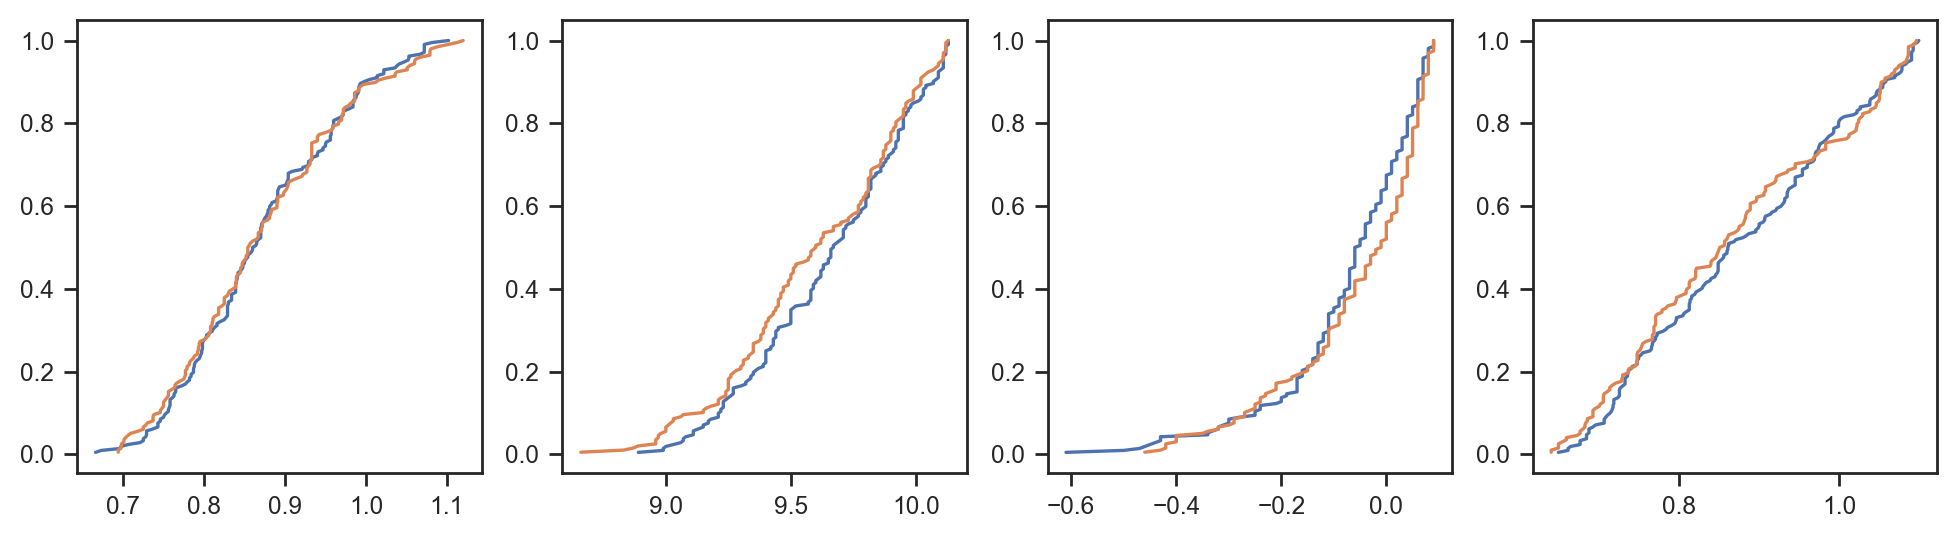

In [387]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)



se = m_FP & m_ms & m_radiusprec &\
    (cks['f18_Miso']>0) &\
    (cks['f18_P']<100) &\
    (cks['single_transit_snr']>0.4) &\
    (abs(cks['f18_[Fe/H]']<0.1)) &\
    (cks['f18_R']<1.1) &\
    (cks['f18_Rp']<1.8) 

sn = m_FP & m_ms & m_radiusprec &\
    (cks['f18_Miso']>0) &\
    (cks['f18_P']<100) &\
    (cks['single_transit_snr']>0.4) &\
    (abs(cks['f18_[Fe/H]']<0.1)) &\
    (cks['f18_R']<1.1) &\
    (cks['f18_Rp']>1.8)


for i,var in enumerate(['f18_Miso','f18_logAiso','f18_[Fe/H]','f18_R']):
    _xse, _yse = ecdf(cks[var][se])
    _xsn, _ysn = ecdf(cks[var][sn])
    
    plt.subplot(1,4,i+1)
    plt.plot(_xse, _yse)
    plt.plot(_xsn, _ysn)
            
plt.gcf().set_size_inches(12,3)
plt.show()
        
# plt.plot(_x, _y)
# _x, _y = ecdf(cks['f18_Miso'][sn])

# plt.show()

# _x, _y = ecdf(cks['f18_logAiso'][se])
# plt.plot(_x, _y)
# _x, _y = ecdf(cks['f18_logAiso'][sn])
# plt.plot(_x, _y)
# plt.show()


# _x, _y = ecdf(cks['f18_[Fe/H]'][se])
# plt.plot(_x, _y)
# _x, _y = ecdf(cks['f18_[Fe/H]'][sn])
# plt.plot(_x, _y)
# plt.show()

# _x, _y = ecdf(cks['f18_R'][se])
# plt.plot(_x, _y)
# _x, _y = ecdf(cks['f18_R'][sn])
# plt.plot(_x, _y)
# plt.show()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in greater_equal
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in less


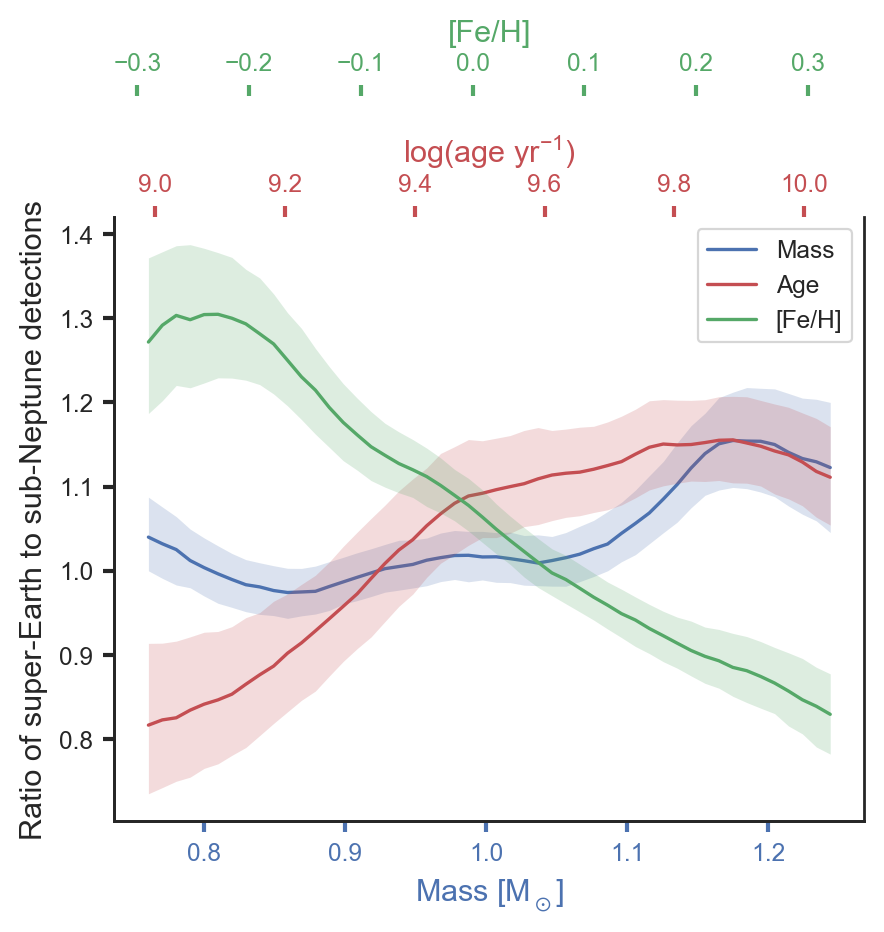

In [1129]:
from scipy import stats
#stats.percentileofscore(cks['f18_Miso'], 0.69)


def feh_sim(cks, m, _binwidth=0.25, nsamples=1000, feh_ref='cks'):
    
    bin_centers = np.linspace(-0.4,0.4,50)
    ratio = np.zeros([len(bin_centers), nsamples])
    
    if feh_ref == 'cks':
        feh_med, feh_err_lo, feh_err_hi = cks['f18_[Fe/H]'], cks['f18_e_[Fe/H]'], cks['f18_E_[Fe/H]']
            
    mc_feh = np.array([np.random.normal(feh_med, np.max([feh_err_lo, feh_err_hi], 
                                                        axis=0)) for n in range(nsamples)])
    m_duplic = np.repeat([m], nsamples, axis=0)
    
    p_duplic = np.repeat([cks['f18_P']], nsamples, axis=0)
    
    Rp_duplic = np.repeat([cks['f18_Rp']], nsamples, axis=0)
    ERp_dupl =  np.repeat([cks['f18_E_Rp']], nsamples, axis=0)
    eRp_dupl =  np.repeat([cks['f18_e_Rp']], nsamples, axis=0)
    
    mc_rp = np.random.normal(Rp_duplic, 
                                 np.max([ERp_dupl,eRp_dupl], axis=0)) - Rp_valley(p_duplic)
    
    #for i in tqdm(range(len(bin_centers))):
    for i in range(len(bin_centers)):          
        mask = m_duplic & (mc_feh>=bin_centers[i]-_binwidth) & (mc_feh<bin_centers[i]+_binwidth)
   
        for j in range(nsamples):
            mc_rp_ = mc_rp[j][mask[j]]
            
            try:
                ratio[i,j] = len(mc_rp_[mc_rp_<0])/len(mc_rp_[mc_rp_>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    
    return bin_centers, ratio


def mass_sim(cks, m, _binwidth=0.25, nsamples=1000, feh_ref='cks'):
    
    bin_centers = np.linspace(0.7,1.5,50)
    ratio = np.zeros([len(bin_centers), nsamples])
    
    if feh_ref == 'cks':
        mass_med, mass_err_lo, mass_err_hi = cks['f18_Miso'], cks['f18_e_Miso'], cks['f18_E_Miso']
            
    mc_mass = np.array([np.random.normal(mass_med, 
                                         np.max([mass_err_lo, mass_err_hi], axis=0)) for n in range(nsamples)])
    m_duplic = np.repeat([m], nsamples, axis=0)
    
    p_duplic = np.repeat([cks['f18_P']], nsamples, axis=0)
    
    Rp_duplic = np.repeat([cks['f18_Rp']], nsamples, axis=0)
    ERp_dupl =  np.repeat([cks['f18_E_Rp']], nsamples, axis=0)
    eRp_dupl =  np.repeat([cks['f18_e_Rp']], nsamples, axis=0)
    
    mc_rp = np.random.normal(Rp_duplic, 
                                 np.max([ERp_dupl,eRp_dupl], axis=0)) - Rp_valley(p_duplic)
    
    for i in range(len(bin_centers)):          
        mask = m_duplic & (mc_mass>=bin_centers[i]-_binwidth) & (mc_mass<bin_centers[i]+_binwidth)
   
        for j in range(nsamples):
            mc_rp_ = mc_rp[j][mask[j]]
            
            try:
                ratio[i,j] = len(mc_rp_[mc_rp_<0])/len(mc_rp_[mc_rp_>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    
    return bin_centers, ratio



def mc_sim(cks, m, var, nsamples=1000, bin_strat='scott'):
    
    if var=='mass':    
        #bin_centers = np.linspace(0.7,1.5,50)
        #_binwidth = 0.2
        _med, _err_lo, _err_hi = cks['f18_Miso'], cks['f18_e_Miso'], cks['f18_E_Miso']
                      
    elif var=='feh':
        #bin_centers = np.linspace(-0.4,0.4,50)
        #_binwidth = 0.3
        _med, _err_lo, _err_hi = cks['f18_[Fe/H]'], cks['f18_e_[Fe/H]'], cks['f18_E_[Fe/H]']
    elif var=='age': 
        #bin_centers = np.linspace(8.5,10,50)
        #_binwidth = 0.5
        _med, _err_lo, _err_hi = cks['f18_logAiso'], cks['f18_e_logAiso'], cks['f18_E_logAiso']
    
    if bin_strat=='scott':
        _binwidth = 3.0*3.49*np.std(_med[m])/(len(_med[m])**(1./3.))
    elif bin_strat=='fd':
        _binwidth = 2.0*stats.iqr(_med[m])/(len(_med[m])**(1./3.))
         
    bin_centers = np.linspace(np.percentile(_med[m], 5.), np.percentile(_med[m], 95), 50)                  
    
    ratio = np.zeros([len(bin_centers), nsamples])

    mc_var = np.array([np.random.normal(_med, 
                                         np.max([_err_lo, _err_hi], axis=0)) for n in range(nsamples)])
    m_duplic = np.repeat([m], nsamples, axis=0)
    
    p_duplic = np.repeat([cks['f18_P']], nsamples, axis=0)
    
    Rp_duplic = np.repeat([cks['f18_Rp']], nsamples, axis=0)
    ERp_dupl =  np.repeat([cks['f18_E_Rp']], nsamples, axis=0)
    eRp_dupl =  np.repeat([cks['f18_e_Rp']], nsamples, axis=0)
    
    mc_rp = np.random.normal(Rp_duplic, 
                                 np.max([ERp_dupl,eRp_dupl], axis=0)) - Rp_valley(p_duplic, ref='RO20')
    
    for i in range(len(bin_centers)):          
        mask = m_duplic & (mc_var>=bin_centers[i]-_binwidth) & (mc_var<bin_centers[i]+_binwidth)
   
        for j in range(nsamples):
            mc_rp_ = mc_rp[j][mask[j]]
            
            try:
                ratio[i,j] = len(mc_rp_[mc_rp_<0])/len(mc_rp_[mc_rp_>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    #stats.percentileofscore(_med[m], bin_centers), 
    return bin_centers, ratio 





def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)





_x = np.arange(50)

# m = m_FP & m_ms &\
#     (cks['f18_P']<100) &\
#     (cks['single_transit_snr']>0.4)

# m = m_FP & m_ms & m_radiusprec &\
#     (cks['f18_P']<100) &\
#     (cks['single_transit_snr']>0.4) &\
#     (cks['f18_[Fe/H]']>0.0)
#     #(cks['f18_R']<1.1)



colors = ['r','g','b']
variables = ['mass', 'age', 'feh']

#fig = plt.figure()
#ax = fig.add_subplot(111)

fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twiny()
par2 = host.twiny()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["top"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)




#mass_bin_centers, mass_ratio = mc_sim(cks, m=m, var='mass')
#feh_bin_centers, feh_ratio = mc_sim(cks, m=m, var='feh')
#age_bin_centers, age_ratio = mc_sim(cks, m=m, var='age')

mass_bin_centers, mass_ratio = mc_sim(cks, m=base_sample, var='mass')
feh_bin_centers, feh_ratio = mc_sim(cks, m=base_sample, var='feh')
age_bin_centers, age_ratio = mc_sim(cks, m=base_sample, var='age')


p1, = host.plot(mass_bin_centers, np.nanmedian(mass_ratio, axis=1), "b-", label="Mass")
p2, = par1.plot(age_bin_centers, np.nanmedian(age_ratio, axis=1), "r-", label="Age")
p3, = par2.plot(feh_bin_centers, np.nanmedian(feh_ratio, axis=1), "g-", label="[Fe/H]")

ci = 68.3

host.fill_between(mass_bin_centers, 
                        np.nanpercentile(mass_ratio, 50.-0.5*ci, axis=1), 
                        np.nanpercentile(mass_ratio, 50.+0.5*ci, axis=1), 
                        alpha=0.2, color='b', lw=0, zorder=999)

par1.fill_between(age_bin_centers, 
                        np.nanpercentile(age_ratio, 50.-0.5*ci, axis=1), 
                        np.nanpercentile(age_ratio, 50.+0.5*ci, axis=1), 
                        alpha=0.2, color='r', lw=0, zorder=999)

par2.fill_between(feh_bin_centers, 
                        np.nanpercentile(feh_ratio, 50.-0.5*ci, axis=1), 
                        np.nanpercentile(feh_ratio, 50.+0.5*ci, axis=1), 
                        alpha=0.2, color='g', lw=0, zorder=999)



# for i,var in enumerate(variables):
    
#     ax2 = ax.twiny()

    


#     ax2.plot(bin_centers, np.nanmedian(_ratio, axis=1), color=colors[i], lw=2, zorder=999)

#     for ci in [68.3]:
#         ax2.fill_between(bin_centers, 
#                         np.nanpercentile(_ratio, 50.-0.5*ci, axis=1), 
#                         np.nanpercentile(_ratio, 50.+0.5*ci, axis=1), 
#                         alpha=0.2, color=colors[i], lw=0, zorder=999)
    
    
    
    

host.set_ylabel('Ratio of super-Earth to sub-Neptune detections', size=11)
host.set_xlabel(r"Mass [$\mathregular{M_\odot}$]", size=11)
par1.set_xlabel(r"log(age yr$^\mathregular{-1}$)", size=11)
par2.set_xlabel("[Fe/H]", size=11)

host.xaxis.label.set_color(p1.get_color())
par1.xaxis.label.set_color(p2.get_color())
par2.xaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='x', colors=p1.get_color(), **tkw)
par1.tick_params(axis='x', colors=p2.get_color(), **tkw)
par2.tick_params(axis='x', colors=p3.get_color(), **tkw)
host.tick_params(axis='y', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines])

    
    
# bin_centers, _ratio = mc_sim(cks, m=m, var='feh')

# ax.plot(_x, np.nanmedian(_ratio, axis=1), color=clr, label='CKS Sun-like stars (this work)', lw=2, zorder=999)

# for ci in [68.3]:
#     ax.fill_between(_x, 
#                  np.nanpercentile(_ratio, 50.-0.5*ci, axis=1), 
#                  np.nanpercentile(_ratio, 50.+0.5*ci, axis=1), 
#                  alpha=0.2, color=clr, lw=0, zorder=999)

# #bin_centers, _ratio = new_fn_speed(cks, m=m, 
# #                              _binwidth=0.5, age_ref='cks', nsamples=1000)
# bin_centers, _ratio = mc_sim(cks, m=m, var='age')
    

# ax.plot(_x, np.nanmedian(_ratio, axis=1), color=clr, label='CKS Sun-like stars (this work)', lw=2, zorder=999)

# for ci in [68.3]:
#     ax.fill_between(np.arange(50), 
#                  np.nanpercentile(_ratio, 50.-0.5*ci, axis=1), 
#                  np.nanpercentile(_ratio, 50.+0.5*ci, axis=1), 
#                  alpha=0.2, color=clr, lw=0, zorder=999)
    

plt.savefig('./figures/trends.pdf')
plt.show()

In [1139]:
print(np.percentile(cks['f18_[Fe/H]'][base_sample], [33., 66.]))

[-0.03  0.11]


In [1140]:
print(np.mean(feh_ratio[feh_bin_centers<-0.03]), np.std(feh_ratio[feh_bin_centers<-0.03]))
print(np.mean(feh_ratio[feh_bin_centers>0.11]), np.std(feh_ratio[feh_bin_centers>0.11]))

1.2291271173516936 0.0934148686864236
0.8947402919385568 0.05278717293906225


In [1113]:
_x = [cks['f18_logAiso'], cks['f18_Miso'], cks['f18_[Fe/H]']]
for __x in _x:
    print(np.percentile(__x[base_sample], [2.5,97.5]))

[ 8.95 10.1 ]
[0.73  1.299]
[-0.35  0.35]


In [896]:
print(np.diff(mass_bin_centers))
print(np.diff(feh_bin_centers))
print(np.diff(age_bin_centers))

[0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653]
[0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653 0.01632653
 0.01632653 0.01632653 0.01632653 0.01632653 0.01

0
94
154
209
297
349
433
510
563
613


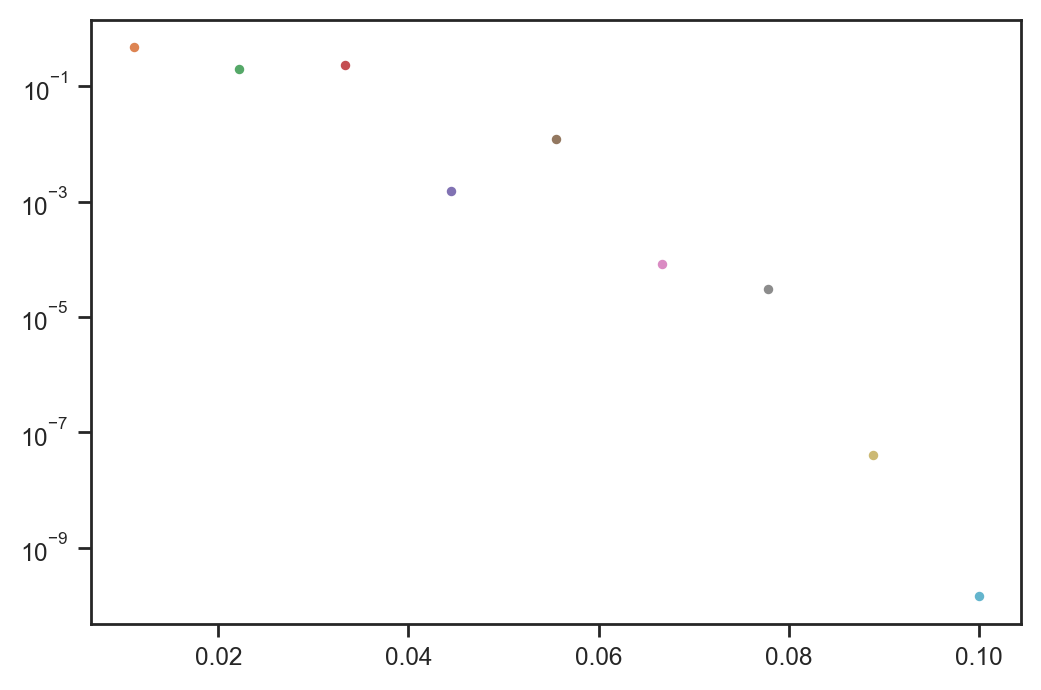

In [371]:
from scipy import stats

m = m_FP & m_ms & (cks['f18_P']<100)
fehmax = np.linspace(0,0.1,10)

for i in range(len(fehmax)):
    
    newm = m & (abs(cks['f18_[Fe/H]'])<fehmax[i])
    
    rho, pval = stats.spearmanr(cks['f18_logAiso'][newm], cks['f18_[Fe/H]'][newm])
    plt.plot(fehmax[i], pval, '.')
    print(len(cks['f18_logAiso'][newm]))
    
plt.semilogy()
plt.show()

# plt.figure(figsize=(6,4))

_binwidth = .1

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe

_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='blue', ecolor='blue', 
        label="all mask SNR .5",linewidth = 2)

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan 
_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)


plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', 
        label="OG SNR .5",linewidth = 2)

plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.title('Normal sampling -- ')
plt.legend()
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
plt.show()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


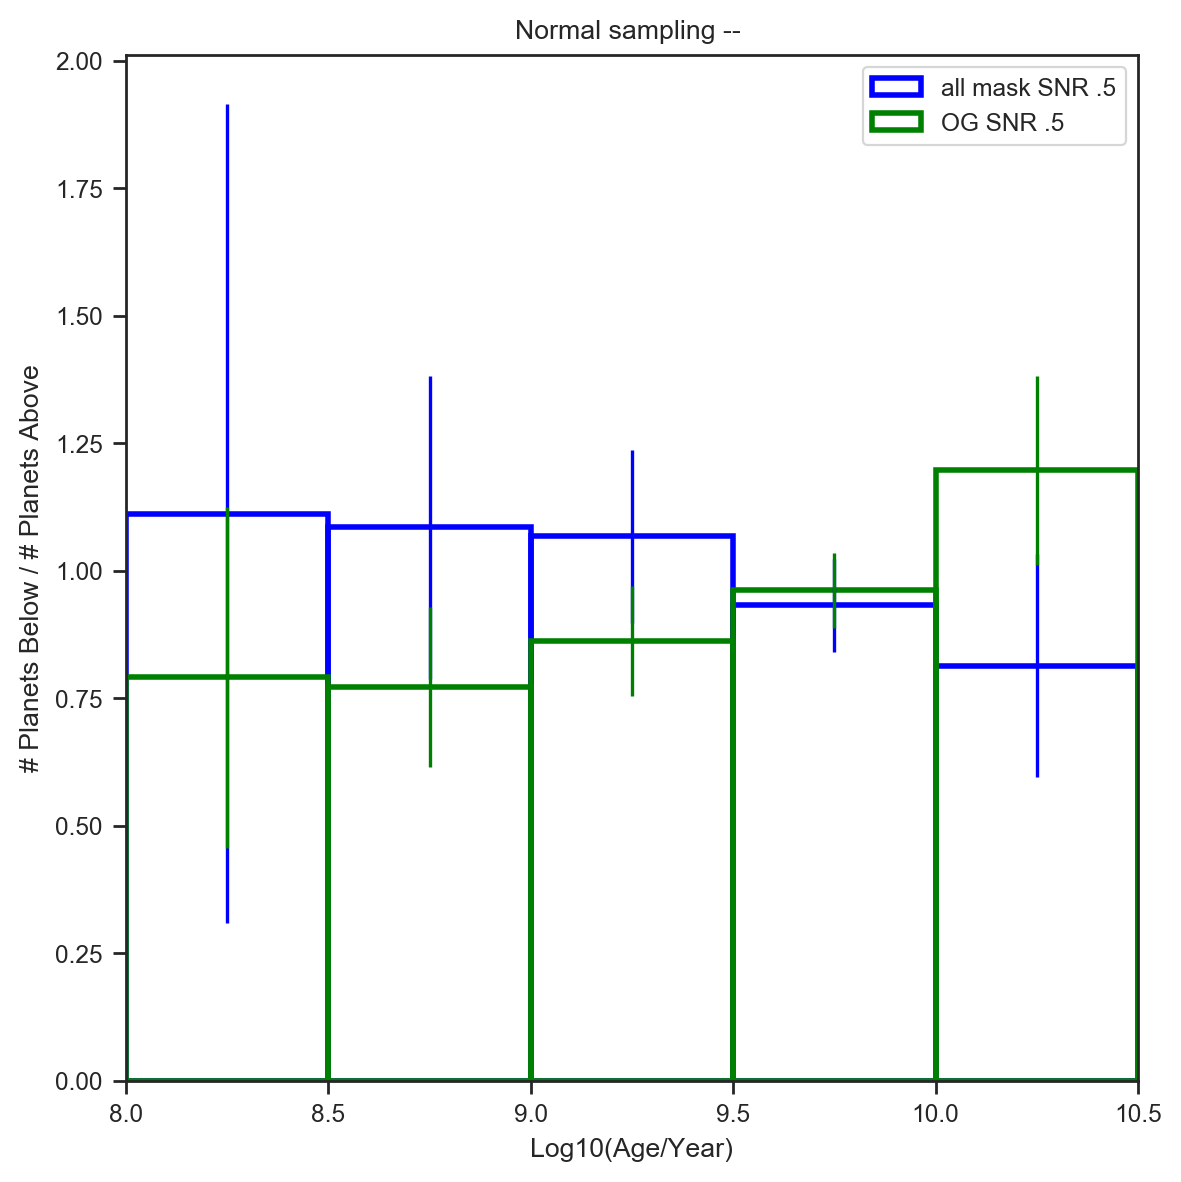

In [53]:
plt.figure(figsize=(6,4))

_binwidth = .5

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe

_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='blue', ecolor='blue', 
        label="all mask SNR .5",linewidth = 2)

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan 
_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)


plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', 
        label="OG SNR .5",linewidth = 2)

plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.title('Normal sampling -- ')
plt.legend()
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
plt.show()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


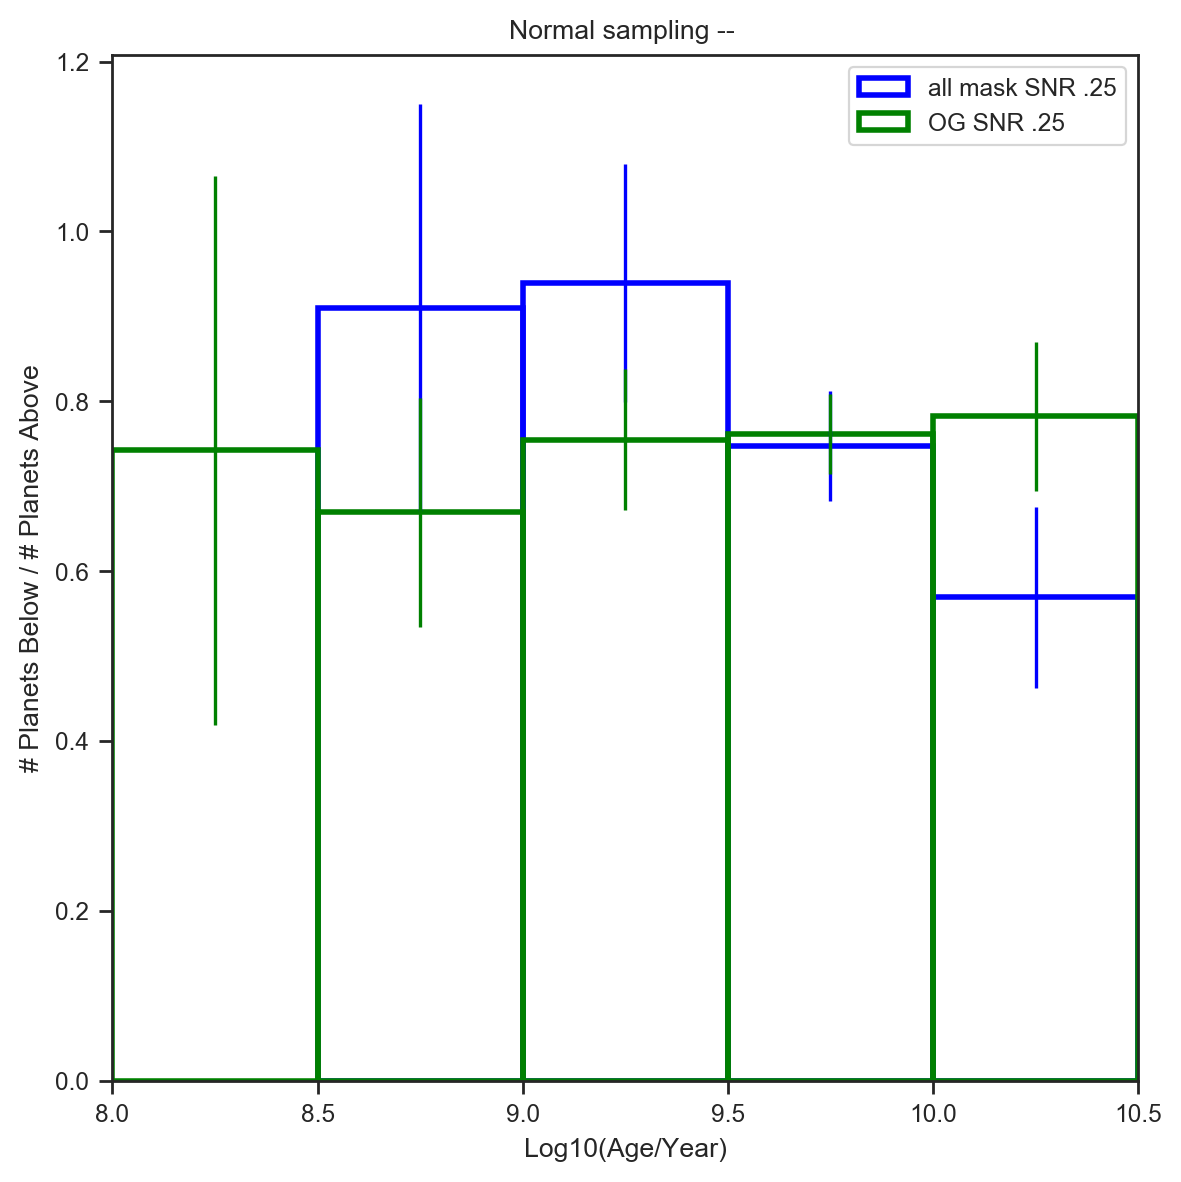

In [54]:
plt.figure(figsize=(6,4))

_binwidth = .5

m = m_multi & m_P & m_snr25 & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe

_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='blue', ecolor='blue', 
        label="all mask SNR .25",linewidth = 2)

m = m_multi & m_P & m_snr25 & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan 
_ratio, bin_centers, _bin_edges = normal_sampling(cks, m, _binwidth=_binwidth)


plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', 
        label="OG SNR .25",linewidth = 2)

plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.title('Normal sampling -- ')
plt.legend()
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
plt.show()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


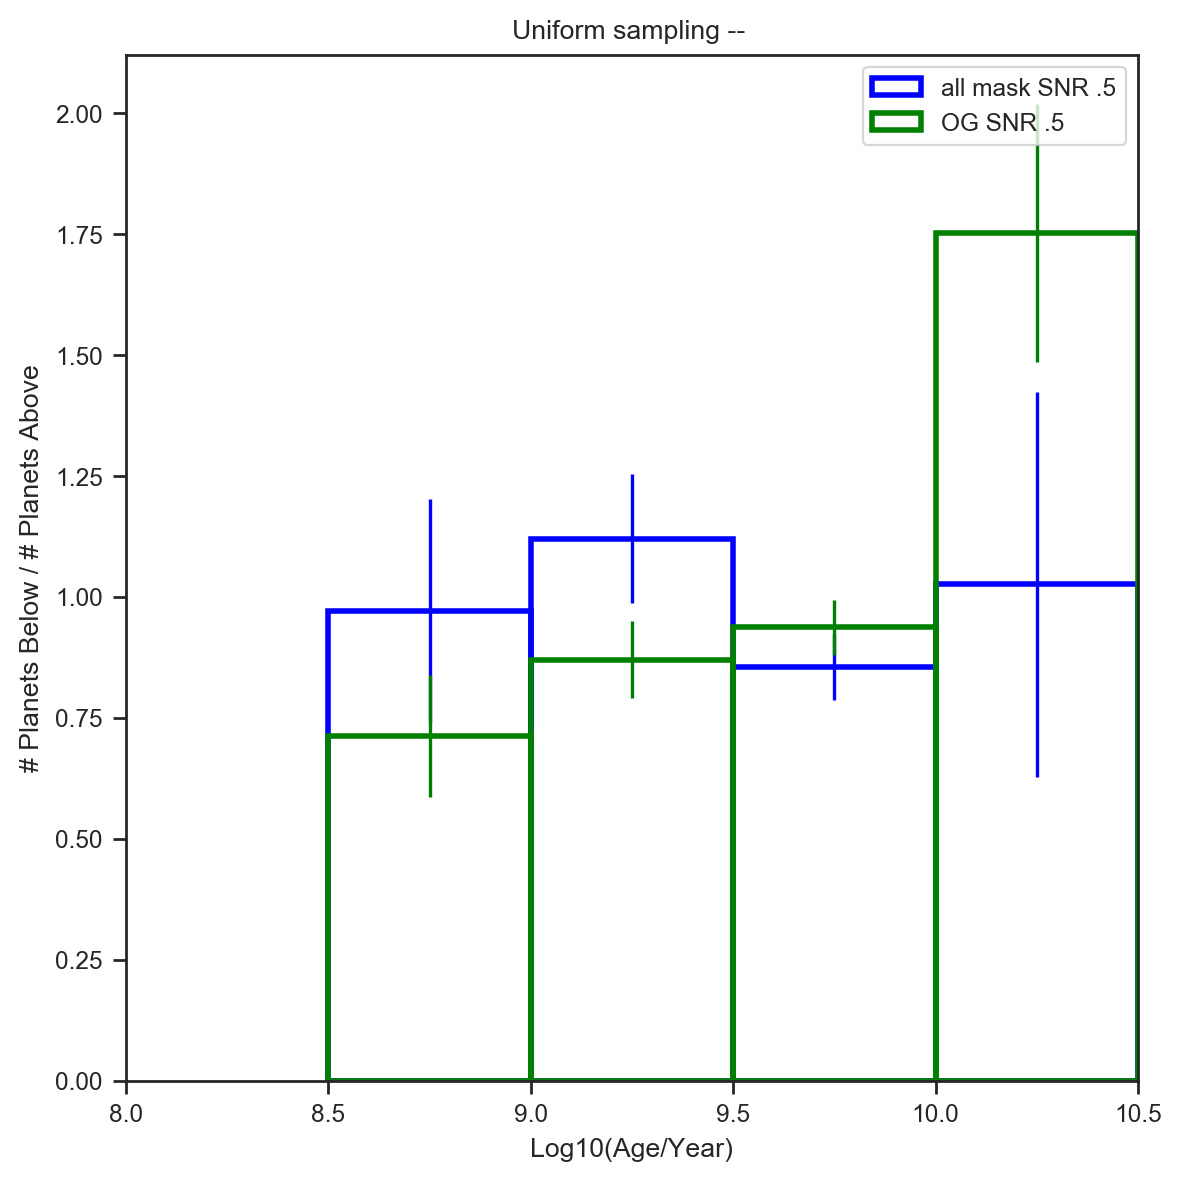

In [55]:
plt.figure(figsize=(6,4))

_binwidth = .5

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe

_ratio, bin_centers, _bin_edges = uniform_sampling(cks, m, _binwidth=_binwidth)
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='blue', ecolor='blue', 
        label="all mask SNR .5",linewidth = 2)

m = m_multi & m_P & m_snr & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan 
_ratio, bin_centers, _bin_edges = uniform_sampling(cks, m, _binwidth=_binwidth)


plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', 
        label="OG SNR .5",linewidth = 2)

plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.title('Uniform sampling -- ')
plt.legend()
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
plt.show()

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


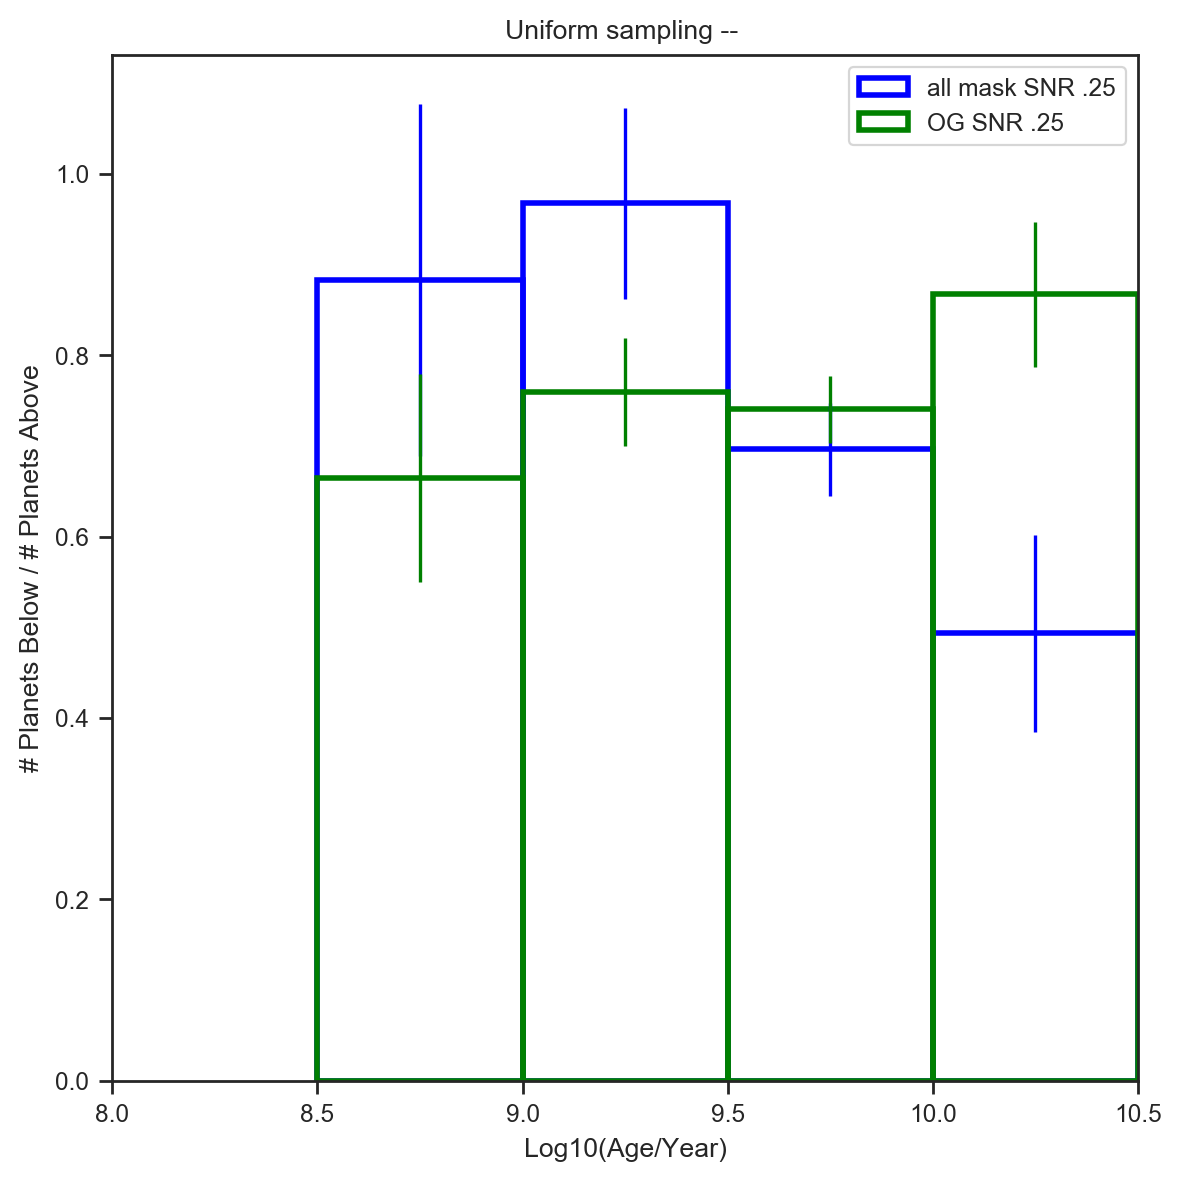

In [56]:
plt.figure(figsize=(6,4))

_binwidth = .5

m = m_multi & m_P & m_snr25 & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan  & m_FP & m_FeH & m_transistdepth & m_disagreementage & m_Rpmin & m_magdisagree & m_red & m_parallaxagree & m_grazing & m_ruwe

_ratio, bin_centers, _bin_edges = uniform_sampling(cks, m, _binwidth=_binwidth)
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='blue', ecolor='blue', 
        label="all mask SNR .25",linewidth = 2)

m = m_multi & m_P & m_snr25 & m_Rstar & m_r8 & m_RCF & m_radiusprec & m_logaisonan 
_ratio, bin_centers, _bin_edges = uniform_sampling(cks, m, _binwidth=_binwidth)


plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', 
        label="OG SNR .25",linewidth = 2)

plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.title('Uniform sampling -- ')
plt.legend()
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
plt.show()

In [352]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices

array([[0, 1],
       [1, 0],
       [2, 1],
       [3, 4],
       [4, 3],
       [5, 4]])

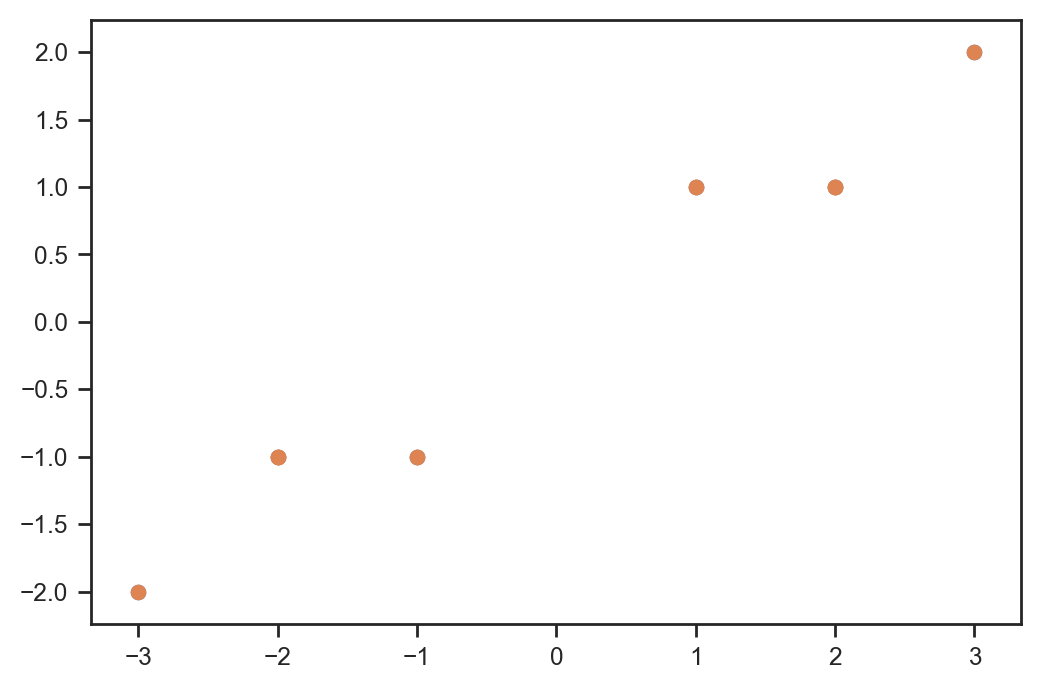

In [354]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[:,0][indices], X[:,1][indices])


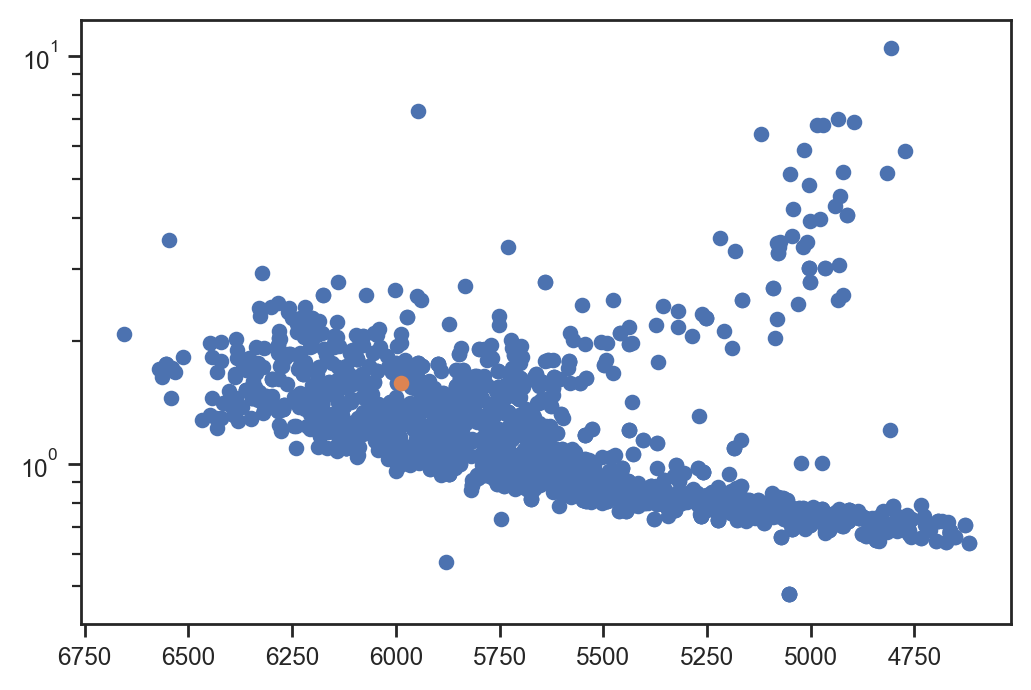

In [359]:
idx = np.random.choice(len(cks))

plt.scatter(cks['f18_Teff'], cks['f18_R'])
plt.scatter(cks['f18_Teff'][idx], cks['f18_R'][idx])
plt.gca().invert_xaxis()
plt.semilogy()
plt.show()

In [ ]:
m = m_FP & m_ms &\
    (cks['f18_P']<60) &\
    (cks['single_transit_snr']>0.4) &\
    (abs(cks['f18_[Fe/H]'])<0.2)# &\